In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame
# from MyLearner import MyLearner

# from MyScorer import MyScorer
# from MyPlotter import MyPlotter

import pandas as pd
import numpy as np
import string
import itertools

import math
import scipy.stats as sts
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
import sklearn.feature_selection as feature_selection
import sklearn.preprocessing as prepc
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.multiclass import OneVsOneClassifier as ovo
from sklearn.multiclass import OutputCodeClassifier as occ
import sklearn
import sklearn.metrics as metrics
from rfpimp import dropcol_importances
from rfpimp import importances
import imblearn.over_sampling as imbOVS
import imblearn.under_sampling as imbUDS
import imblearn.combine as imbCMB

from dabl.plot import class_hists

c:\00_data\python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

### Training Set

In [3]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test Set

In [4]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Checking missing values in training set

In [5]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls

,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


Seems to be a lot of missing values in 'Age' and 'Cabin'.

As I concluded from preliminary analysis, the Age is one of the critical and must be treated first.

The Cabin and Embarked are probably not important in Survival prediction.

I will come to nulls later but for now lets look on distributions.

### Checking missing values in test set

In [6]:
nulls = data_test.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,86
Fare,1
Cabin,327


#### Calculate survival rate

In [7]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


Well, only 1/3 survived. That was expectable though.

In [8]:
data = data_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()

#encode categorical variables
data['Sex'] = data['Sex'].apply(lambda i: 1 if i=='male' else 0)
data['Embarked'] = data['Embarked'].apply(lambda i: 0 if i=='C' else (1 if i=='Q' else 2))
data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
# data = pd.concat([data.drop(columns=['Sex', 'Embarked']), df1, df2], axis=1)

#add family size
data['famsize'] = data['SibSp'] + data['Parch']

#numerical data
data_num = data[['Age', 'Fare',]]

#categorical data
data_cat = data[['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch', 'famsize']]

In [9]:
data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,famsize
0,0,2,1,22.0,1,0,7.2500,2,1
1,1,0,0,38.0,1,0,71.2833,0,1
2,1,2,0,26.0,0,0,7.9250,2,0
3,1,0,0,35.0,1,0,53.1000,2,1
4,0,2,1,35.0,0,0,8.0500,2,0


### Plotting Variables

In [10]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

In [11]:
def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

In [12]:
def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

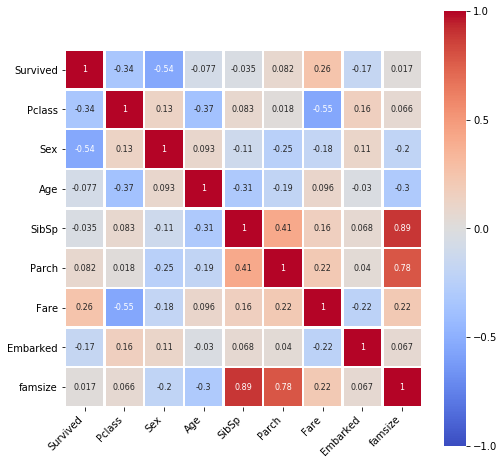

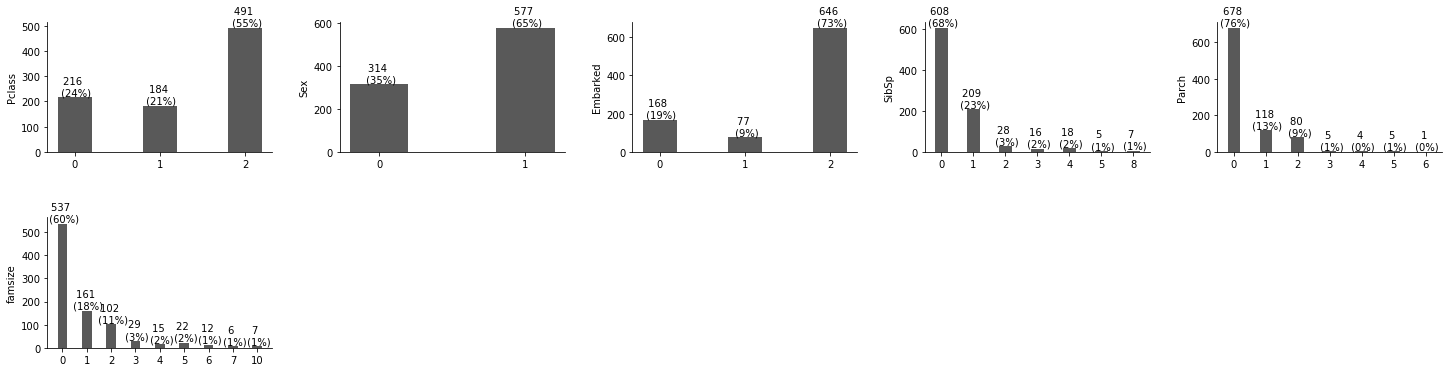

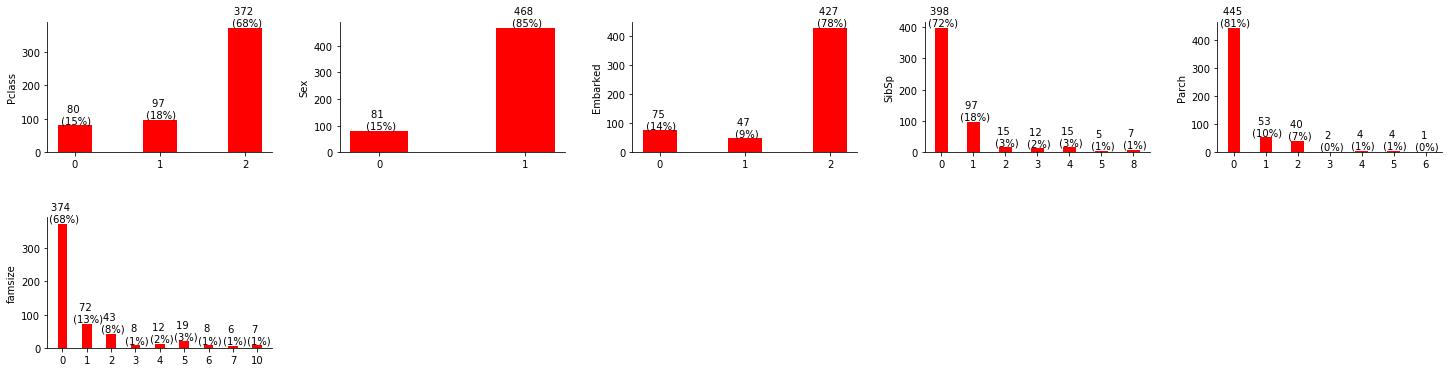

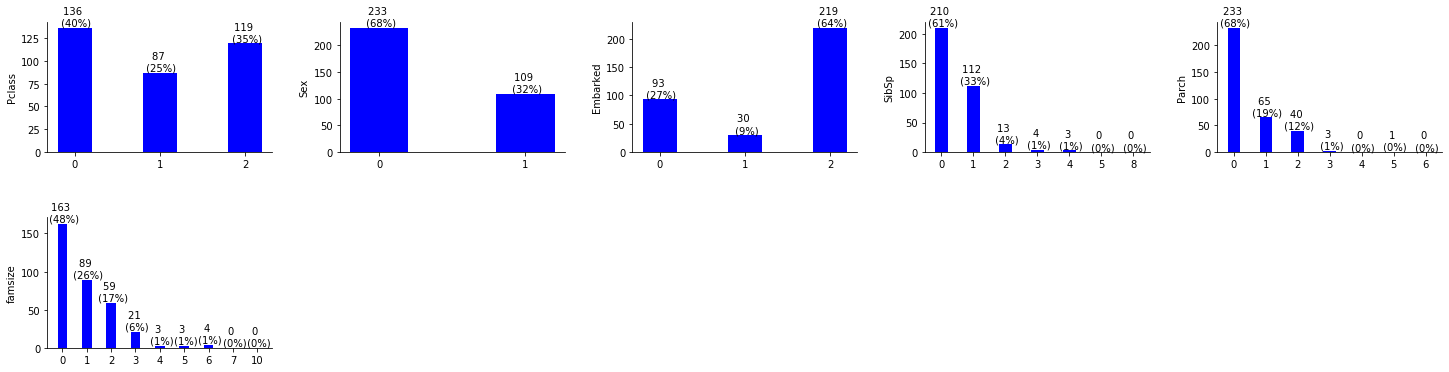

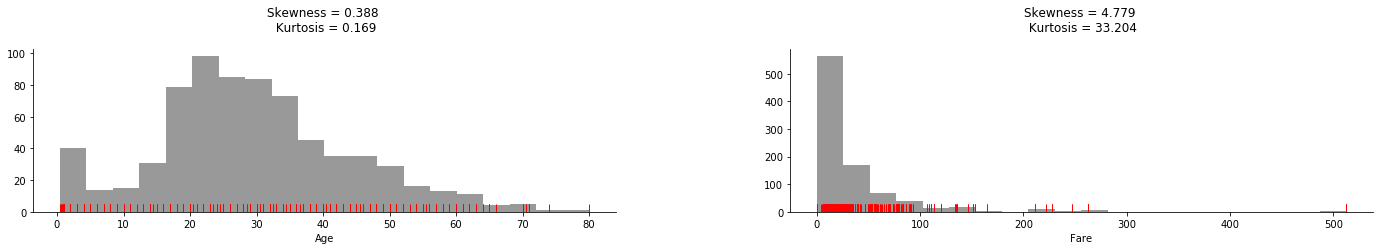

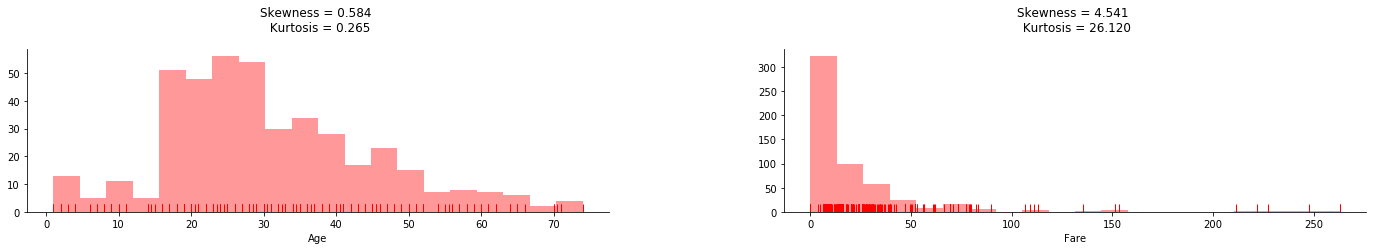

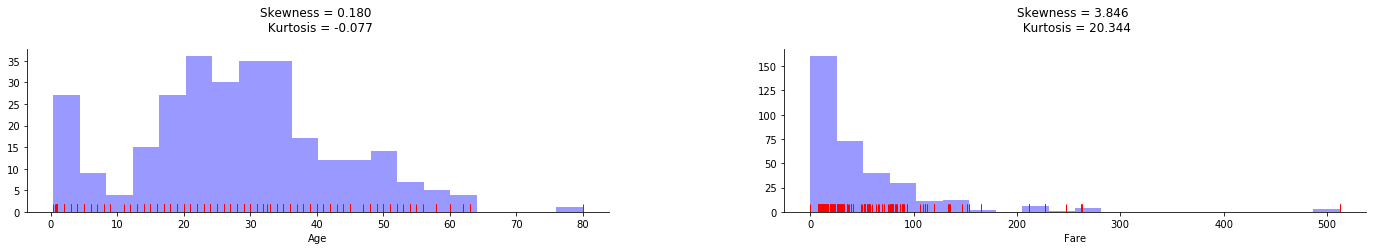

In [13]:
#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='coolwarm')


grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 5
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 5

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n = len(data.loc[data[col]==i, col].index)
        fr = n / len(data.index)
        freq.append([n])
        frc.append([fr])

    df_freq = pd.DataFrame(freq, columns=['all'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['all'], index=data_cat[col].unique()).T
    labs = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['all'], df_frc.loc['all'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs],
                           plots_labels=None,
                           plots_colors=['0.35'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    

    
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data[col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


#### Define age intervals using clastering

In [14]:
#Transform 'Age'
df_age = data_train['Age'].dropna()

age_trans = df_age.apply(lambda i: np.log(i+1)).to_frame()
age_trans.columns = ['Age_trans']
df_age = pd.concat([df_age.to_frame(), age_trans], axis=1)

In [15]:
#Define clustering model
age_clast_model = mix.BayesianGaussianMixture(n_components=2, covariance_type='spherical', tol=0.001, reg_covar=1e-06, max_iter=1000, n_init=1, 
                                 init_params='kmeans', weight_concentration_prior_type='dirichlet_distribution', 
                                 weight_concentration_prior=None, mean_precision_prior=None, mean_prior=None, 
                                 degrees_of_freedom_prior=None, covariance_prior=None, random_state=30)
                                 
#Predict class labels
age_cls = pd.DataFrame(age_clast_model.fit_predict(np.array(df_age['Age_trans']).reshape(-1,1)), columns=['Age_cls'])
age_cls = age_cls.astype(int)

In [16]:
df_age = pd.concat([df_age.reset_index(), age_cls], axis=1).drop(columns='index')

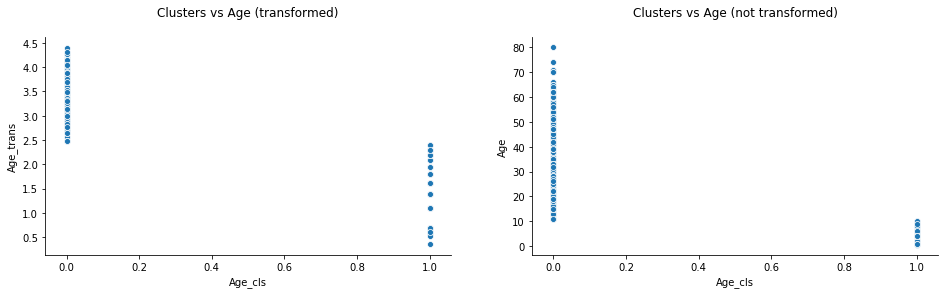

In [17]:
fig = plt.figure()
fig.set_size_inches(16,4)

fig.add_subplot(1,2,1)
ax = sns.scatterplot(x='Age_cls', y='Age_trans', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (transformed)')

fig.add_subplot(1,2,2)
ax = sns.scatterplot(x='Age_cls', y='Age', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (not transformed)')

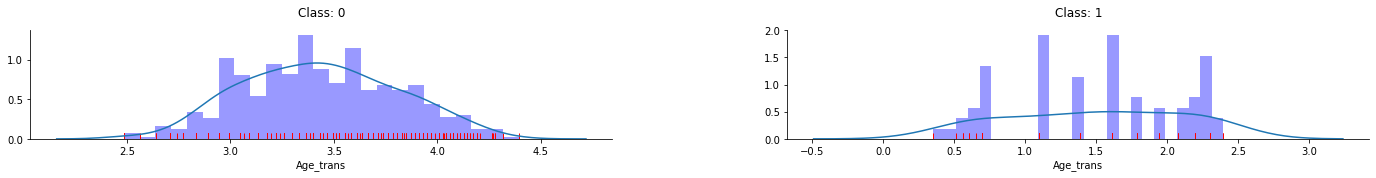

In [18]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age_trans']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

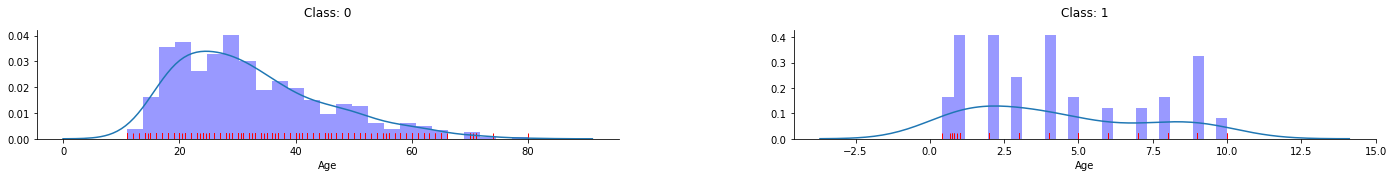

In [19]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

In [20]:
def age_transformer(data, model):
    age_trans = np.array(data['Age'].apply(lambda i: np.log(i+1))).reshape(-1,1)
    age_cls = pd.DataFrame(model.fit_predict(age_trans), columns=['Age_cls'])
    age_cls = age_cls.astype(int)
    data = pd.concat([data.drop(columns=['Age']).reset_index(), pd.DataFrame(age_trans, columns=['Age'])], axis=1).drop(columns='index')
    return pd.concat([data.reset_index(), age_cls], axis=1).drop(columns='index')

#### Replace 'Name' with encoded titles

In [21]:
#Concatinate train & test data
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [22]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(), data_encoded], axis=1).drop(columns=['index'])

In [23]:
data_tot = name_encoder(data_tot)
data_tot.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Thayer,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Peel,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,,Mr


In [24]:
#Find unique titles and their counts
ttl = data_tot['ttl'].unique()
ttl = pd.DataFrame([[i, len(data_tot.loc[data_tot['ttl']==i])] for i in ttl], columns=['ttl', 'ttl_n'])
ttl.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
ttl,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer,Dona
ttl_n,757,197,260,61,1,8,8,1,2,2,1,1,2,4,1,1,1,1


In [25]:
#Explore samples with 'Dr' title
data_tot.loc[data_tot['ttl']=='Dr']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
245,246,0.0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,Minahan,,Dr
317,318,0.0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,Moraweck,,Dr
398,399,0.0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Pain,,Dr
632,633,1.0,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,Stahelin-Maeglin,,Dr
660,661,1.0,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,Frauenthal,,Dr
766,767,0.0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,Brewe,,Dr
796,797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Leader,Farnham,Dr
1184,1185,NaN,1,"Dodge, Dr. Washington",male,53.0,1,1,33638,81.8583,A34,S,Dodge,,Dr


_**There is only one woman with title 'Dr'._

The function below will replace each person's name with encoded title. Instead of using all unique titles, I will teke only these: 'Mr', 'Mrs', 'Miss' and 'Master'.

In [26]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    df = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    data = pd.concat([data.drop(columns=['ttl']), df], axis=1)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    df = data['ttl'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['ttl']), df], axis=1)

In [27]:
data_tot = title_encoder(data_tot)

#### Explore missing values for 'Embarked'

In [28]:
data_tot.loc[data_tot['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,,3
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,Evelyn,2


Display samples with similar ticket number

In [29]:
df = data_tot.query('Ticket.str.contains("1135")')
df.sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
782,783,0.0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S,Long,,1
377,378,0.0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,Widener,,1
965,966,NaN,1,"Geiger, Miss. Amalie",female,35.0,0,0,113503,211.5000,C130,C,Geiger,,3
966,967,NaN,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5000,C132,C,Keeping,,1
1109,1110,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C,Widener,Elkins,2
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,Widener,,1
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,Chibnall,Bowerman,2
356,357,1.0,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S,Bowerman,,3
54,55,0.0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,Ostby,,1
917,918,NaN,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C,Ostby,,3


All people with similar ticket numbers are embarked in 'C' or 'S'. So i will simply assign the most frequent class for both missed values.

In [30]:
nc = len(df.loc[df['Embarked']=='C'])
ns = len(df.loc[df['Embarked']=='S'])
n = len(df.index)

print('C: %d' % nc)
print('S: %d' % ns)
print('All: %d' % n)

C: 7
S: 5
All: 14


The function below will be used to encode 'Embarked' variable

In [31]:
#Encoding 'Embarked'
def embarked_encoder(data):
#     data = data.copy()
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data
            
#Encoding 'Pclass'
def pclass_encoder(data):
#     data = data.copy()
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

In [32]:
data_tot = embarked_encoder(data_tot)
data_tot = pclass_encoder(data_tot)

### Grouping by ticket ID

While exploring the dataset, I found that many passengers have identical ticket numbers as well as identical fare value.

In this section I will do two things:
1. Group all passengers by ticked ID and add a column of the gropus IDs.
2. For all people with matching tickets, I will recalculate ticket fare for every i-th person in a group g as: fare(i, g) = fare(g) / n, where n is a number of people in group g.

~~3. Transform fare into categorical variable.~~

In [33]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

In [34]:
# This function will clean ticket ID from all punctuation and spaces
def ticket_encoder(data):
    df = data['Ticket'].apply(lambda i: clean_text(i)).to_frame()
    data = pd.concat([data.drop(columns=['Ticket']).reset_index(), df], axis=1)
    return data.drop(columns=['index'])

In [35]:
data_tot = ticket_encoder(data_tot)

Numbers of unique and non-unique tickets:

In [36]:
print('Unique tickets: %d' % len(data_tot['Ticket'].unique()))
print('Non-unique tickets: %d' % (len(data_tot.index) - len(data_tot['Ticket'].unique())))

Unique tickets: 929
Non-unique tickets: 380


I want to define the following groups:
1. No family (SibSp==0 & Parch==0), unique tickets
2. No family (SibSp==0 & Parch==0), non-unique tickets
3. Has family, no children (SibSp >0 & Parch==0), unique tickets
4. Has family, no children (SibSp >0 & Parch==0), non-unique tickets
5. Has family, has children (Parch >0), unique tickets
6. Has family, has children (Parch >0), non-unique tickets

In [37]:
families0 = data_tot.loc[(data_tot['SibSp']>0) & (data_tot['Parch']==0)]
families1 = data_tot.loc[data_tot['Parch']>0]
singles = data_tot.loc[(data_tot['SibSp']==0) & (data_tot['Parch']==0)]

In [38]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [39]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

print('Singles-----------------------')
print('Matching tickets groups: %d' % len(sig1.index))
print('Unique tickets groups: %d' % len(sig0.index))
print('------------------------------')

print('Families----------------------')
print('Matching tickets groups: %d' % len(fam1.index))
print('Unique tickets groups: %d' % len(fam0.index))
print('------------------------------')

print('Families W/children-----------')
print('Matching tickets groups: %d' % len(famch1.index))
print('Unique tickets groups: %d' % len(famch0.index))
print('------------------------------')

Singles-----------------------
Matching tickets groups: 108
Unique tickets groups: 682
------------------------------
Families----------------------
Matching tickets groups: 174
Unique tickets groups: 38
------------------------------
Families W/children-----------
Matching tickets groups: 288
Unique tickets groups: 19
------------------------------


In [40]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [41]:
# Encode family groups
def family_groups_encoder(data, fam_grps):
#     data = data.copy()
    data['fgrp'] = 0
    for idx, grp in enumerate(fam_grps):
        for pid in grp['PassengerId']:
            data.loc[data['PassengerId']==pid, 'fgrp'] = idx
    return data

In [42]:
# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class.
def fare_encoder(data, encode_grps):
    for grp in encode_grps:
        fare = grp['Fare'].values[0] / len(grp.index)
        grp['Fare'] = fare
        for pid in grp['PassengerId']:
            if pid in data['PassengerId']:
                data.loc[data['PassengerId']==pid, 'Fare'] = fare
    if len(data.loc[data['Fare'].isnull()])>0:
        for pid in data.loc[data['Fare'].isnull(), 'PassengerId']:
            c = data.loc[data['PassengerId']==pid, 'Pclass'].values[0]
            data.loc[data['PassengerId']==pid, 'Fare'] = np.mean(data.loc[data['Pclass']==c, 'Fare'])
    return data

In [43]:
def family_encoder(data, match_ticket_grps):
#     data = data.copy()
    data['mtickets'] = 0
    data['famsize'] = data['SibSp'] + data['Parch']
    data['SibSp'] = data['SibSp'].apply(lambda i: 1 if i > 0 else 0)
    data['Parch'] = data['Parch'].apply(lambda i: 1 if i > 0 else 0)
    for pid in data['PassengerId']:
        for grp in match_ticket_grps:
            if pid in grp['PassengerId']:
                data.loc[data['PassengerId']==pid, 'mtickets'] = 1
    return data

In [44]:
# Encode fare
def fare_transformer(data):
#     data = data.copy()
    data['Fare'] = data['Fare'].apply(lambda i: np.log(i+1))
#     kbd = prepc.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
#     c = pd.DataFrame(kbd.fit_transform(np.array(data['Fare']).reshape(-1,1)), columns=['Fare'])
#     c = c.astype(int)
#     data = pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')
    return data

In [45]:
data_tot = family_groups_encoder(data_tot, fam_grps)
data_tot = family_encoder(data_tot, [sig1, fam1, famch1])
data_tot = fare_encoder(data_tot, [sig1, fam1, famch1])
# data_tot = fare_transformer(data_tot)

Functions for sex encoding and to add a family size variable:

In [46]:
# Encode 'Sex'
def sex_encoder(data):
#     data = data.copy()
    mask = {'male':0, 'female':1}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

In [47]:
# Add 'Familie size'
def fam_size(data):
#     data = data.copy()
    data['famsize'] = data['SibSp'] + data['Parch']
    return data

In [48]:
def combine_features(data, feature1, feature2, name):
    lst1 = list(data[feature1].unique())
    lst2 = list(data[feature2].unique())
    d1 = len(lst1)
    d2 = len(lst2)
    mask = np.array(range(d1 * d2)).reshape(d1,d2)
    data = data.copy()
    df = []
    for i in data.index:
        df.append([mask[lst1.index(data[feature1][i])][lst2.index(data[feature2][i])]])
    df = pd.DataFrame(df, columns=[name])
    return pd.concat([data.reset_index(), df], axis=1).drop(columns='index')

In [49]:
data_tot = sex_encoder(data_tot)
# data_tot = fam_size(data_tot)
data_tot = combine_features(data_tot, 'Pclass', 'Embarked', 'PclEmb')

In [50]:
data_tot.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked', 'lname0', 'lname1', 'ttl', 'Ticket',
       'fgrp', 'mtickets', 'famsize', 'Sex', 'PclEmb'],
      dtype='object')

### Predict missing missing values for age

In [301]:
data = data_tot[data_tot['Age'].notna()].copy()
# data = data[['Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'famsize']]
data = data[['Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'mtickets', 'SibSp', 'Parch', 'famsize']]

In [302]:
data = age_transformer(data, age_clast_model)

In [53]:
# data = fare_transformer(data)

Plot correlation matrix:

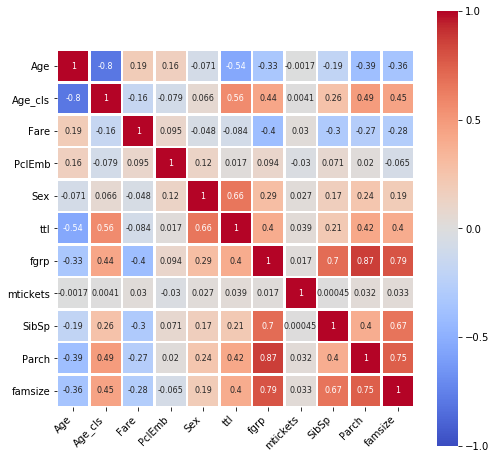

In [54]:
data = data[['Age', 'Age_cls', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'mtickets', 'SibSp', 'Parch', 'famsize']]
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

In [55]:
# def add_counts(data, columns):
#     n = len(data.index)
#     for col in columns:
# #         data['{0}_n'.format(col)] = data[col].apply(lambda i: len(data.loc[data[col]==i].index) / n)
#         data[col] = data[col].apply(lambda i: np.log(i+1)) + data[col].apply(lambda i: len(data.loc[data[col]==i].index) / n)
#     return data

In [56]:
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

In [57]:
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

In [58]:
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

In [59]:
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

In [60]:
def dropcol_imp_r2_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.r2_score(y_valid, y_pred, sample_weight=sample_weights)

In [61]:
def dropcol_imp_roc_auc_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.roc_auc_score(y_valid, y_pred, sample_weight=sample_weights)

In [62]:
def dropcol_imp_accuracy_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.accuracy_score(y_valid, y_pred, sample_weight=sample_weights)

In [63]:
    def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
        """Plots confusion matrix
        Parameters:
        ax =  matplotlib axes
        normalyze = normalization over truth (number_predicted / total_count_of_this_class)
        """
        model.fit(X,y)
        conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                                  labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
        classes = y.unique()
        classes.sort()
        n_classes = [len(y[y == c]) for c in classes]
        if normalize == True:
            n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
            norm_matrix = conf_matrix / np.array(n_classes)
            ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
            labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                                   ns_matrix[i, j]) for j, v in
                                enumerate(norm_matrix[i])]
                               for i, v in enumerate(norm_matrix)])

            sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
        else:
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        
        ax.set_ylabel('True Labels')
        ax.set_xlabel('Predicted Labels')
        if title is None:
            title = model.__class__.__name__
        ax.set_title(title)
        ttl = ax.title
        ttl.set_position([.5, 1.07])

        # fix for mpl bug that cuts off top/bottom of seaborn viz
        b, t = ax.get_ylim()  # discover the values for bottom and top
        b += 0.5  # Add 0.5 to the bottom
        t -= 0.5  # Subtract 0.5 from the top
        ax.set_ylim(b, t)  # update the ylim(bottom, top) values

In [64]:
def feature_importance(model, X_train, y_train, X_test, y_test, metric, label=None):
    feature_importance = dropcol_importances(model, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=metric)
    if label is None:
        label = model.__class__.__name__
    feature_importance.columns = [label]
    return feature_importance

In [65]:
def roc_auc_score_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovr', labels=None)

def roc_auc_score_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovo', labels=None)

In [303]:
data.columns

Index(['Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'mtickets', 'SibSp', 'Parch',
       'famsize', 'Age', 'Age_cls'],
      dtype='object')

In [369]:
# train test split
X = data.drop(columns=['Age', 'Age_cls', 'Sex', 'mtickets', 'SibSp', 'Parch', 'famsize'])
y = data['Age_cls']

In [370]:
X.columns

Index(['Fare', 'PclEmb', 'ttl', 'fgrp'], dtype='object')

In [371]:
X['Fare'] = X['Fare'].apply(lambda i: i * len(X.loc[X['Fare']==i].index))

In [69]:
# X['Fare'] = X['Fare'].apply(lambda i: np.log(i+1))

In [70]:
# X['famsize'] = X['famsize'].apply(lambda i: np.log(i+1))

In [372]:
#common random_state
random_state=30

#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)

#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

In [308]:
age_cls_model = gaup.GaussianProcessClassifier(kernel=None, random_state=random_state)
param_ranges = {'max_iter_predict': np.arange(1, 15)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.943222  0.991308         0.928657
std_train            0.031217  0.001641         0.016530
mean_test            0.925869  0.987066         0.927257
std_test             0.042587  0.006267         0.026137
{'max_iter_predict': 5}


In [ ]:
#             balanced_accuracy   roc_auc  precision_macro
# mean_train           0.955640  0.991468         0.927666
# std_train            0.021246  0.001537         0.015733
# mean_test            0.941003  0.982810         0.934234
# std_test             0.044713  0.008042         0.017774
# {'max_iter_predict': 4}

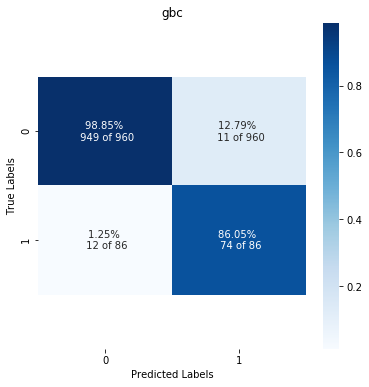

In [309]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(age_cls_model, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='gbc')

In [310]:
age_cls_model = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini')
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'max_depth': np.arange(3, 10)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 15)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.959400  0.993194         0.922249
std_train            0.027921  0.001578         0.018494
mean_test            0.945965  0.991370         0.925341
std_test             0.027986  0.003445         0.024607
{'max_depth': 8, 'n_estimators': 5}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.953978  0.992099         0.910009
std_train            0.031839  0.002017         0.015165
mean_test            0.944657  0.987522         0.903193
std_test             0.024438  0.009670         0.033141
{'ccp_alpha': 0.001}


In [311]:
#             balanced_accuracy   roc_auc  precision_macro
# mean_train           0.963860  0.993304         0.922353
# std_train            0.022406  0.001601         0.018546
# mean_test            0.951792  0.992083         0.923854
# std_test             0.027910  0.003166         0.025828
# {'max_depth': 9, 'n_estimators': 25}

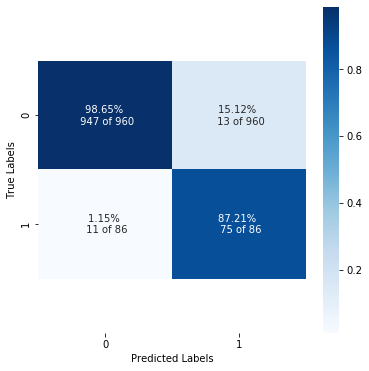

In [312]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(age_cls_model, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

Optimal number of features : 4
Features to drop: 

[]


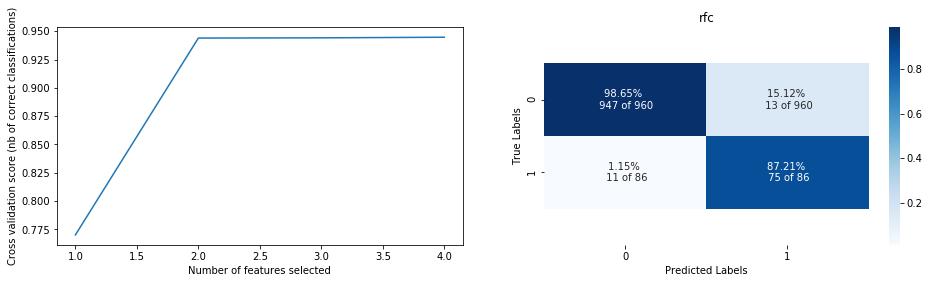

In [313]:
rfecv = feature_selection.RFECV(estimator=age_cls_model, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(age_cls_model, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [381]:
age_cls_model = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                               random_state=random_state,
                                               validation_fraction=0.1, 
                                               ccp_alpha=0.0)
param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 10), 'n_estimators': np.arange(5, 100, 20)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'min_impurity_decrease': np.linspace(0.001, 0.01, 15)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'subsample': np.linspace(0.1, 1.1, 15), 'max_depth': np.arange(3, 6)}
# age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.0001,0.001, 20)}
# age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.968232  0.993662         0.964094
std_train            0.021518  0.001253         0.002137
mean_test            0.950927  0.991183         0.948978
std_test             0.032781  0.002848         0.032639
{'learning_rate': 0.1577777777777778, 'n_estimators': 65}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.972258  0.993346         0.910289
std_train            0.016774  0.001350         0.018040
mean_test            0.962754  0.991654         0.900663
std_test             0.030999  0.002650         0.027943
{'min_impurity_decrease': 0.0035714285714285718, 'min_weight_fraction_leaf': 0.03111111111111111}


In [ ]:
#             balanced_accuracy   roc_auc  precision_macro
# mean_train           0.968232  0.993567         0.964094
# std_train            0.021518  0.001354         0.002137
# mean_test            0.950927  0.991183         0.948978
# std_test             0.032781  0.003148         0.032639
# {'learning_rate': 0.1366666666666667, 'n_estimators': 85}
#             balanced_accuracy   roc_auc  precision_macro
# mean_train           0.972258  0.993968         0.902298
# std_train            0.016774  0.001289         0.014695
# mean_test            0.960754  0.991564         0.895723
# std_test             0.033608  0.002657         0.018870
# {'min_impurity_decrease': 0.0013214285714285715, 'min_weight_fraction_leaf': 0.03111111111111111}

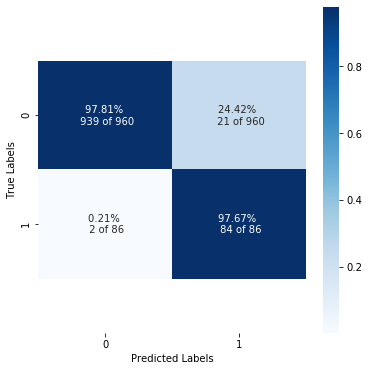

In [345]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(age_cls_model, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [387]:
# train test split
X = data.drop(columns=['Age', 'Sex', 'mtickets', 'SibSp', 'Parch', 'famsize'])
y = data['Age']

In [388]:
# X['Fare'] = X['Fare'].apply(lambda i: np.log(i+1))

In [389]:
# X['famsize'] = X['famsize'].apply(lambda i: np.log(i+1))

In [390]:
X.columns

Index(['Fare', 'PclEmb', 'ttl', 'fgrp', 'Age_cls'], dtype='object')

In [391]:
X['Fare'] = X['Fare'].apply(lambda i: i * len(X.loc[X['Fare']==i].index))

In [392]:
#Train/Test split
# X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.1, shuffle=True, random_state=30)
#common random_state
random_state=30
#cross validation strategy
cv_folds = 5
# n_repeats = 10
# cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
#cross validation metrics
scoring = {'explained_variance':  'explained_variance',
           'r2': 'r2'}
refit='r2'

In [349]:
age_reg_mogel = ens.RandomForestRegressor(min_samples_split = 2, min_samples_leaf = 1, random_state=random_state, n_jobs=-1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.746231  0.746225
std_train             0.010447  0.010448
mean_test             0.698567  0.696909
std_test              0.059901  0.060376
{'max_depth': 5, 'n_estimators': 85}


In [353]:
param_ranges = {'ccp_alpha': np.linspace(0.0001,0.01, 20)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.736813  0.736808
std_train             0.010730  0.010731
mean_test             0.699253  0.697522
std_test              0.060076  0.060584
{'ccp_alpha': 0.0011421052631578948}


In [394]:
age_reg_mogel = ens.GradientBoostingRegressor(loss='ls', criterion='friedman_mse', random_state=random_state)
param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 10), 'n_estimators': np.arange(5, 100, 20)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'min_impurity_decrease': np.linspace(0.0001, 0.01, 20)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.00001,0.0001, 20)}
# age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.743033  0.743033
std_train             0.010360  0.010360
mean_test             0.705845  0.704205
std_test              0.057204  0.057664
{'learning_rate': 0.09444444444444444, 'n_estimators': 45}


In [ ]:
#             explained_variance        r2
# mean_train            0.743046  0.743046
# std_train             0.010325  0.010325
# mean_test             0.704529  0.702876
# std_test              0.057631  0.058117
# {'learning_rate': 0.052222222222222225, 'n_estimators': 85}
#             explained_variance        r2
# mean_train            0.727034  0.727034
# std_train             0.011283  0.011283
# mean_test             0.702042  0.700331
# std_test              0.060046  0.060697
# {'min_impurity_decrease': 2.2857142857142858e-05, 'min_weight_fraction_leaf': 0.052222222222222225}
#             explained_variance        r2
# mean_train            0.726954  0.726954
# std_train             0.011327  0.011327
# mean_test             0.702095  0.700385
# std_test              0.060058  0.060710
# {'ccp_alpha': 5.2631578947368424e-05}

In [86]:
rfecv = feature_selection.RFECV(estimator=age_reg_mogel, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print('Features to drop: {0}'.format(feats))

Optimal number of features : 5
Features to drop: []


### Preprocess train set for classification

**Pipeline:**
1. Encode name
2. Encode title
3. Encode embarked
4. Encode familie groups
5. Encode fare
6. Encode sex
7. Add familie size
8. Encode age

In [87]:
#Age encoder
def age_predictor(data, age_cls_model, age_reg_mogel):
#     data = fare_transformer(data)
#     cols = ['Fare', 'Pclass', 'Sex', 'ttl', 'fgrp', 'famsize', 'Embarked']
    cols = ['Fare', 'PclEmb', 'ttl', 'fgrp']
    data_na = data[data['Age'].isnull()]
    data_notna = data[data['Age'].notna()]

    # transform non-null age values
    age_trans = data_notna['Age'].apply(lambda i: np.log(i+1)).to_frame()
    data_notna = pd.concat([data_notna.drop(columns=['Age']), age_trans], axis=1)

    # predict class labels
    X = data_na[cols].reset_index().drop(columns='index')
    age_cls = pd.Series(age_cls_model.predict(X), name='Age_cls').to_frame()
    X_age_cls = pd.concat([X, age_cls], axis=1)

    # predict age
    age_preds = pd.Series(age_reg_mogel.predict(X_age_cls), name='Age').to_frame()
    data_na = pd.concat([data_na.reset_index().drop(columns=['Age', 'index']), age_preds], axis=1)
    return pd.concat([data_na, data_notna])
#     data = pd.concat([data_na, data_notna])
    
#     kbd = prepc.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
#     c = pd.DataFrame(kbd.fit_transform(np.array(data['Age']).reshape(-1,1)), columns=['Age_cls'])
#     c = c.astype(int)
#     return pd.concat([data.reset_index(), c], axis=1).drop(columns='index')

In [88]:
data_train1 = name_encoder(data_train)
data_train1 = title_encoder(data_train1)
data_train1 = embarked_encoder(data_train1)
data_train1 = pclass_encoder(data_train1)
data_train1 = family_groups_encoder(data_train1, fam_grps)
data_train1 = family_encoder(data_train1, [sig1, fam1, famch1])
data_train1 = fare_encoder(data_train1, [sig1, fam1, famch1])
data_train1 = sex_encoder(data_train1)
data_train1 = combine_features(data_train1, 'Pclass', 'Embarked', 'PclEmb')
# data_train1 = fam_size(data_train1)
data_train1 = age_predictor(data_train1, age_cls_model, age_reg_mogel)

In [89]:
#Predict class labels
# age_cls = pd.DataFrame(age_clast_model.fit_predict(np.array(data_train1['Age']).reshape(-1,1)), columns=['Age_cls'])
# age_cls = age_cls.astype(int)
# # age_cls
# data_train1 = pd.concat([data_train1.reset_index(), age_cls], axis=1).drop(columns='index')

In [90]:
# data_train1

In [99]:
data = data_train1[['Survived','Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'ttl', 'fgrp', 'mtickets', 'famsize', 'Sex', 'PclEmb', 'Age']]
data_cat = data[['Pclass', 'SibSp', 'Parch', 'Embarked', 'ttl','fgrp', 'mtickets','Sex', 'PclEmb']]
data_num = data[['Fare', 'famsize', 'Age']]

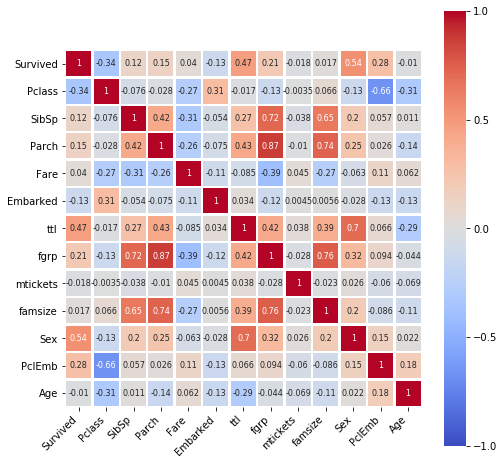

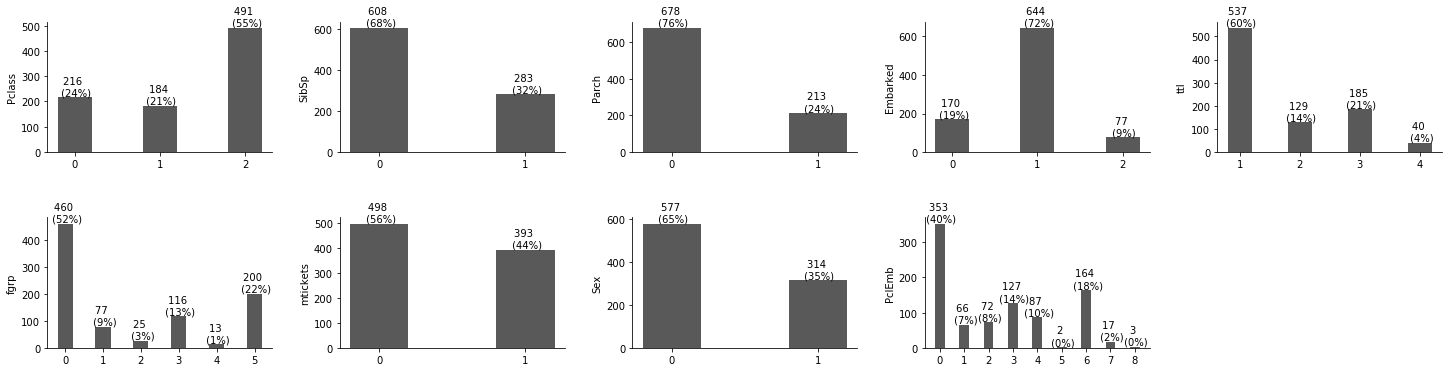

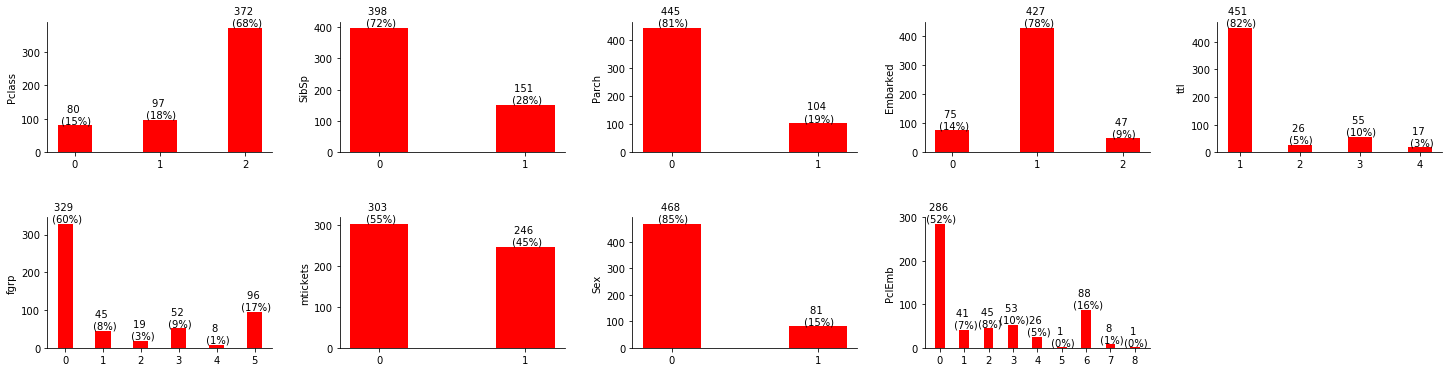

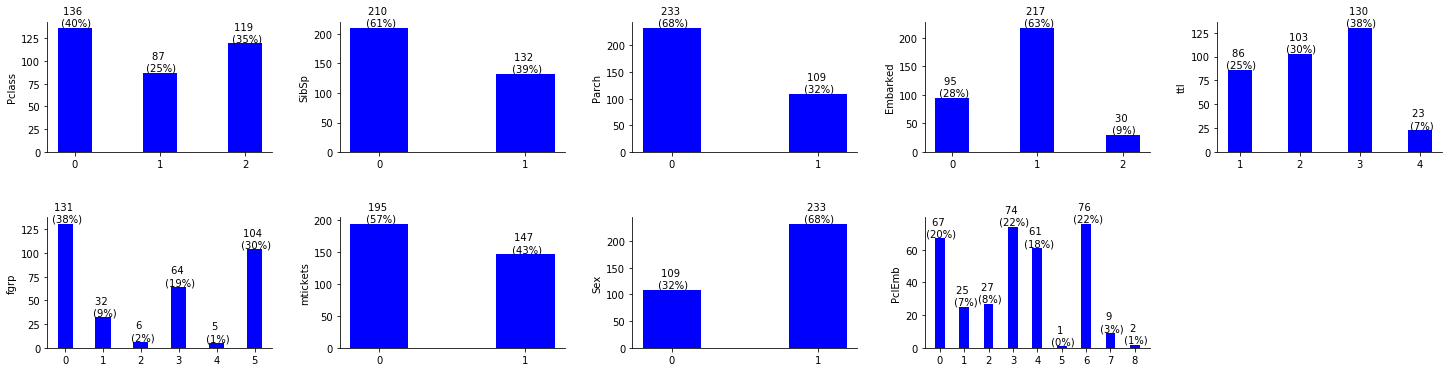

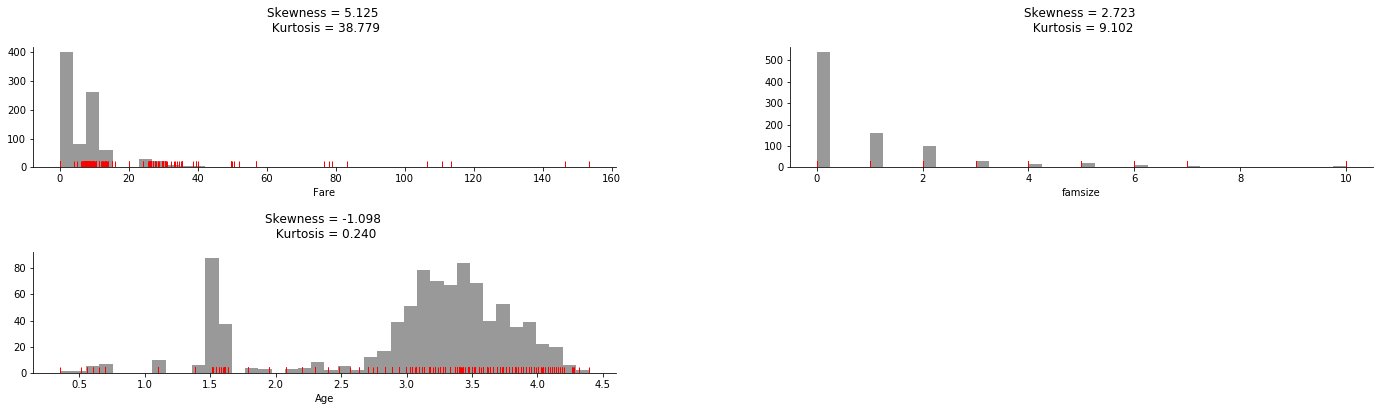

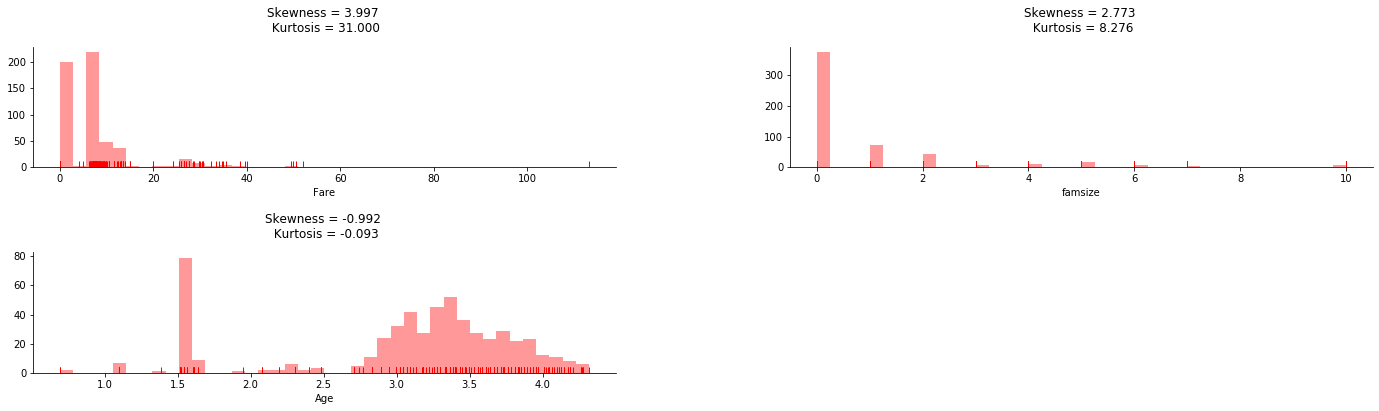

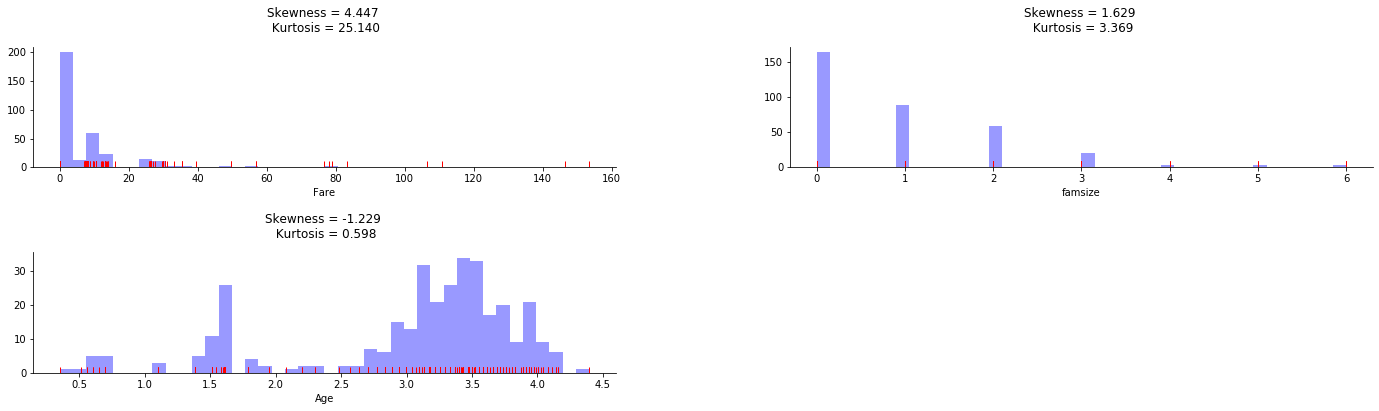

In [100]:
#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 5
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 5

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n = len(data.loc[data[col]==i, col].index)
        fr = n / len(data.index)
        freq.append([n])
        frc.append([fr])

    df_freq = pd.DataFrame(freq, columns=['all'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['all'], index=data_cat[col].unique()).T
    labs = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['all'], df_frc.loc['all'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs],
                           plots_labels=None,
                           plots_colors=['0.35'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    

    
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data[col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


In [93]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [94]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
#         print(model.predict_proba(X))
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
#         print(proba_0)
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

In [117]:
data1['famsize'].unique()

array([ 0,  1,  2, 10,  4,  3,  6,  5,  7], dtype=int64)

In [124]:
data1 = data[['Survived', 'Age', 'Fare', 'fgrp', 'famsize', 'ttl', 'PclEmb']].copy()

In [125]:
data1['Fare'] = data1['Fare'].apply(lambda i: np.log((i+1) * len(data1.loc[data1['Fare']==i].index)))

In [126]:
data1['ttl'] = data1['ttl'].apply(lambda i: i * len(data1.loc[data1['ttl']==i].index))

In [127]:
data1['fgrp'] = data1['fgrp'].apply(lambda i: (i+1) * len(data1.loc[data1['fgrp']==i].index))

In [128]:
data1['famsize'] = data1['famsize'].apply(lambda i: np.log((i+1) * len(data1.loc[data1['famsize']==i].index)))

In [129]:
data1['PclEmb'] = data1['PclEmb'].apply(lambda i: (i+1) * len(data1.loc[data1['PclEmb']==i].index))

In [130]:
data1['Age'] = data1['Age'].apply(lambda i: np.log(i * len(X.loc[data1['Age']==i].index)))

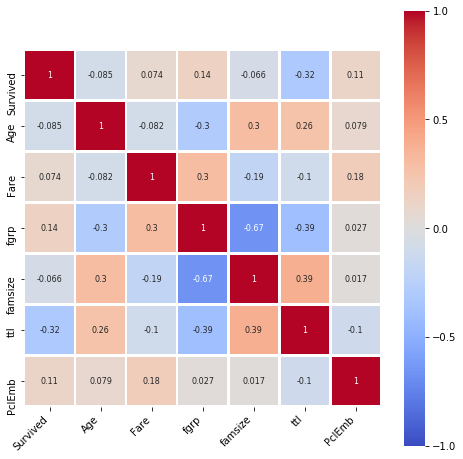

In [131]:

fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data1.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

In [236]:
# train test split
# X = data.drop(columns=['Survived', 'Pclass', 'Embarked', 'SibSp', 'Parch', 'Age_cls', 'Sex', 'mtickets'])
X = data.drop(columns=['Survived', 'Pclass', 'Embarked', 'fgrp', 'Sex', 'SibSp', 'Parch', 'mtickets'])
y = data['Survived']

In [870]:
# def add_counts(data, columns):
#     n = len(data.index)
#     for col in columns:
# #         data['{0}_n'.format(col)] = data[col].apply(lambda i: len(data.loc[data[col]==i].index) / n)
#         data[col] = data[col].apply(lambda i: np.log(i+1)) + data[col].apply(lambda i: len(data.loc[data[col]==i].index) / n)
#     return data

In [871]:
# X = add_counts(X, ['Pclass', 'ttl', 'Embarked', 'Sex', 'Fare', 'Age', 'famsize', 'fgrp'])

In [237]:
X['Fare'] = X['Fare'].apply(lambda i: np.log((i+1) * len(X.loc[X['Fare']==i].index)))

In [134]:
X['ttl'] = X['ttl'].apply(lambda i: i * len(X.loc[X['ttl']==i].index))

In [135]:
X['fgrp'] = X['fgrp'].apply(lambda i: (i+1) * len(X.loc[X['fgrp']==i].index))

In [179]:
X['famsize'] = X['famsize'].apply(lambda i: np.log((i+1) * len(X.loc[X['famsize']==i].index)))

In [137]:
X['PclEmb'] = X['PclEmb'].apply(lambda i: (i+1) * len(X.loc[X['PclEmb']==i].index))

In [238]:
X['Age'] = X['Age'].apply(lambda i: np.log(i * len(X.loc[X['Age']==i].index)))

In [152]:
X.columns

Index(['Fare', 'ttl', 'fgrp', 'famsize', 'PclEmb', 'Age'], dtype='object')

In [239]:
X

,Fare,ttl,famsize,PclEmb,Age
0,2.246893,1,0,2,4.326310
1,6.327937,1,0,6,4.326310
2,4.592085,2,0,1,1.150547
3,4.592085,1,0,1,4.326310
4,3.570006,3,0,2,3.417044
...,...,...,...,...,...
885,5.299277,2,5,2,3.944380
886,6.327937,1,0,6,4.094006
887,5.043425,3,0,3,4.316065
889,5.043425,1,0,4,4.083032


In [241]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

In [240]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [184]:
bm = [('gpc', gaup.GaussianProcessClassifier()),
      ('lda', disan.LinearDiscriminantAnalysis()),
      ('qda', disan.QuadraticDiscriminantAnalysis()),
      ('abc', ens.AdaBoostClassifier()),
      ('gbc', ens.GradientBoostingClassifier()),
      ('etc', ens.ExtraTreesClassifier()),
      ('rfc', ens.RandomForestClassifier()),
      ('lr', lm.LogisticRegression()),
      ('pac', lm.PassiveAggressiveClassifier()),
      ('rc', lm.RidgeClassifier()),
      ('svc', svm.SVC()),
      ('lsvc', svm.LinearSVC()),
      ('nusvc', svm.NuSVC())]

In [185]:
for m in bm:
    lbl, model = m
    print(lbl)
    print(cv_rep(model, X, y, cv, scoring))
    print('\n')

gpc
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.833363  0.896298         0.861442
std_train            0.011581  0.010157         0.012046
mean_test            0.783254  0.851477         0.811277
std_test             0.020574  0.019719         0.013196


lda
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.753917  0.821589         0.783634
std_train            0.013249  0.011114         0.011973
mean_test            0.737746  0.811212         0.775310
std_test             0.023805  0.019610         0.018986


qda
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.778377  0.838087         0.808548
std_train            0.013484  0.015566         0.015380
mean_test            0.761712  0.826417         0.795790
std_test             0.020570  0.018462         0.024765


abc
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.844043  0.918762         0.854859
std_train

In [186]:
for m in bm:
    lbl, mdl = m
    mdl.fit(X,y)

c:\00_data\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


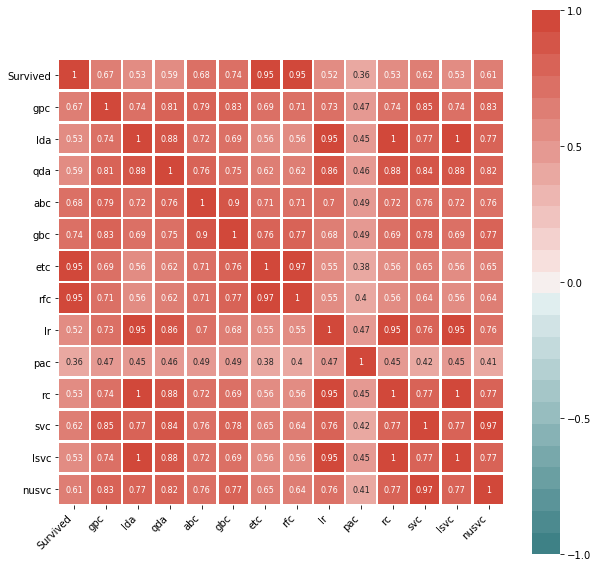

In [187]:
preds_base = base_models_predictions(bm, X)
preds_base = pd.concat([y.reset_index().drop(columns=['index']), preds_base], axis=1)
# data = pd.concat([pd.DataFrame(final_model_surv_st.predict_proba(X_test), columns=['final_pred_0', 'final_pred_1']), data], axis=1)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

c:\00_data\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


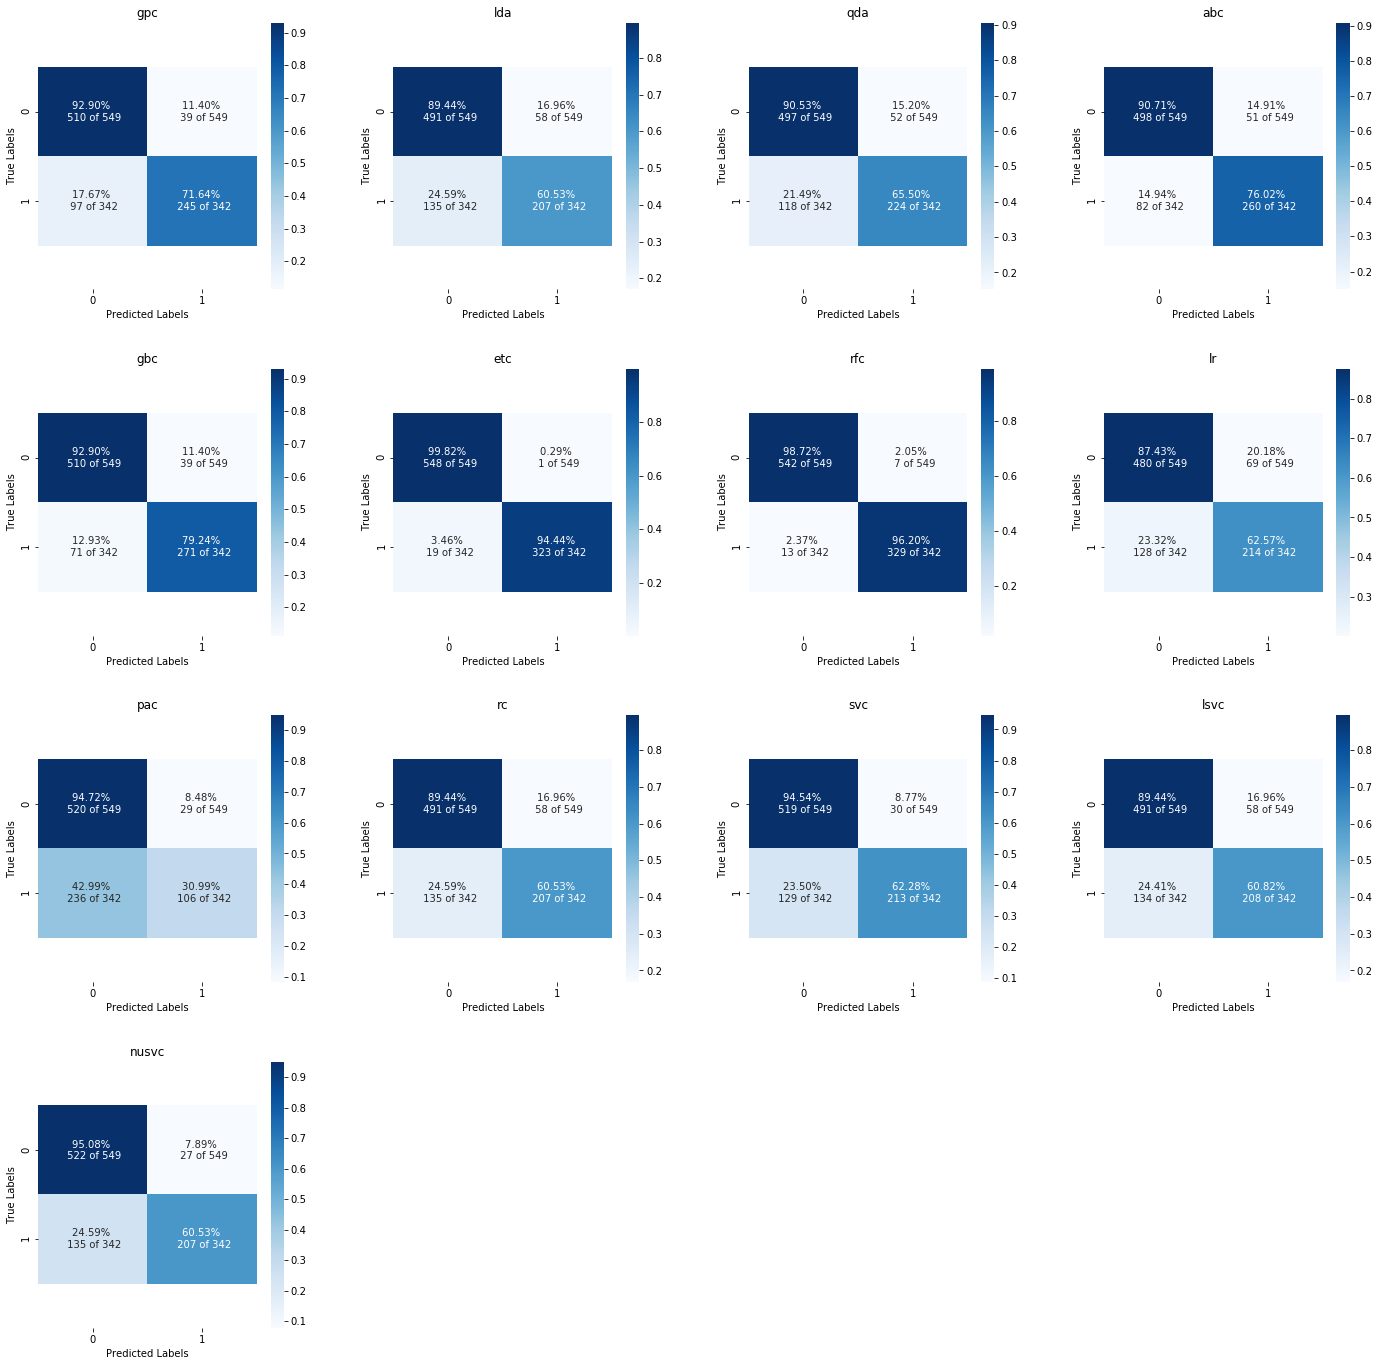

In [188]:
grd_n = len(bm)
grd_cols_n = 4
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(bm):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [189]:
bm = [('gpc', gaup.GaussianProcessClassifier()),
      ('qda', disan.QuadraticDiscriminantAnalysis()),
      ('abc', ens.AdaBoostClassifier()),
      ('gbc', ens.GradientBoostingClassifier()),
      ('rfc', ens.RandomForestClassifier()),
      ('lr', lm.LogisticRegression()),
      ('svc', svm.SVC())]

In [190]:
for m in bm:
    lbl, mdl = m
    mdl.fit(X,y)

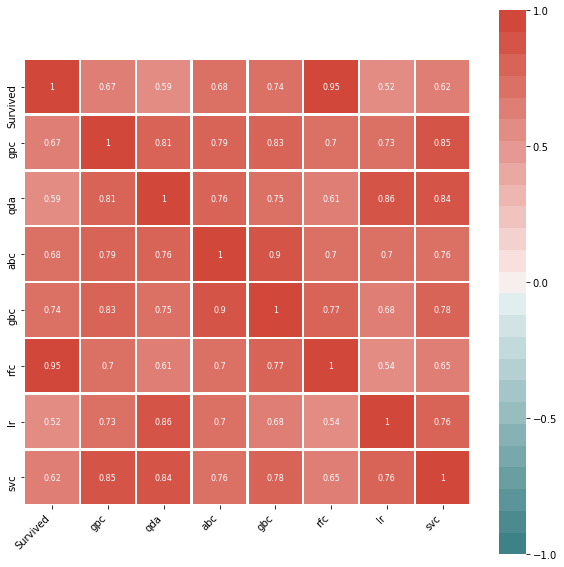

In [191]:
preds_base = base_models_predictions(bm, X)
preds_base = pd.concat([y.reset_index().drop(columns=['index']), preds_base], axis=1)
# data = pd.concat([pd.DataFrame(final_model_surv_st.predict_proba(X_test), columns=['final_pred_0', 'final_pred_1']), data], axis=1)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [192]:
model_st = ens.StackingClassifier(estimators=bm,
                                          final_estimator=ens.RandomForestClassifier(),
                                          cv=5, 
                                          stack_method='predict', 
                                          n_jobs=-1)
cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.839539,0.895183,0.859699
std_train,0.021913,0.048552,0.025627
mean_test,0.776049,0.813686,0.793315
std_test,0.027049,0.028161,0.030919


In [174]:
param_ranges = {'final_estimator__n_estimators': np.arange(5, 100, 20),
                'final_estimator__max_depth': np.arange(5, 10)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.850104  0.932610         0.879784
std_train            0.023319  0.035671         0.019237
mean_test            0.785813  0.828076         0.806330
std_test             0.027714  0.020773         0.033080
{'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 45}


In [ ]:
#             balanced_accuracy   roc_auc  precision_macro
# mean_train           0.866195  0.954677         0.872832
# std_train            0.026866  0.010690         0.017522
# mean_test            0.799162  0.836181         0.814810
# std_test             0.020743  0.021361         0.021353
# {'final_estimator__max_depth': 6, 'final_estimator__n_estimators': 65}

In [175]:
model_st = ens.StackingClassifier(estimators=bm,
                                  final_estimator=ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                                                                 random_state=random_state),
                                  cv=5, 
                                  stack_method='predict', 
                                  n_jobs=-1)
cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.857046,0.917699,0.878737
std_train,0.024925,0.047466,0.020258
mean_test,0.779862,0.818753,0.803794
std_test,0.031528,0.030518,0.033319


In [176]:
param_ranges = {'final_estimator__learning_rate': np.linspace(0.01, 0.2, 10), 'final_estimator__n_estimators': np.arange(5, 100, 20)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'final_estimator__min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'final_estimator__min_impurity_decrease': np.linspace(0.01, 0.2, 15)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'final_estimator__subsample': np.linspace(0.1, 1.1, 15), 'final_estimator__max_depth': np.arange(3, 6)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.858785  0.941907         0.882371
std_train            0.019361  0.034751         0.015942
mean_test            0.793698  0.835513         0.823926
std_test             0.027955  0.020870         0.030705
{'final_estimator__learning_rate': 0.07333333333333333, 'final_estimator__n_estimators': 25}


KeyboardInterrupt: 

In [ ]:
#             balanced_accuracy   roc_auc  precision_macro
# mean_train           0.860970  0.919394         0.884612
# std_train            0.022748  0.030616         0.026270
# mean_test            0.804257  0.859085         0.827527
# std_test             0.029019  0.025302         0.017158
# {'final_estimator__learning_rate': 0.07333333333333333, 'final_estimator__n_estimators': 45}
#             balanced_accuracy   roc_auc  precision_macro
# mean_train           0.866901  0.928181         0.883499
# std_train            0.017934  0.041218         0.017013
# mean_test            0.805405  0.860715         0.822761
# std_test             0.024991  0.021781         0.028451
# {'final_estimator__min_impurity_decrease': 0.07785714285714285, 'final_estimator__min_weight_fraction_leaf': 0.1577777777777778}
#             balanced_accuracy   roc_auc  precision_macro
# mean_train           0.869580  0.928204         0.881244
# std_train            0.018240  0.032593         0.018056
# mean_test            0.806617  0.862127         0.824344
# std_test             0.024819  0.020453         0.023312
# {'final_estimator__max_depth': 5, 'final_estimator__subsample': 0.17142857142857143}

### Magic Features

In [106]:
X.columns

Index(['Fare', 'ttl', 'fgrp', 'famsize', 'PclEmb', 'Age'], dtype='object')

            explained_variance        r2
mean_train            0.494851  0.526915
std_train             0.079274  0.034103
mean_test             0.520311  0.573588
std_test              0.160996  0.151909
{'max_depth': 4, 'n_estimators': 5}


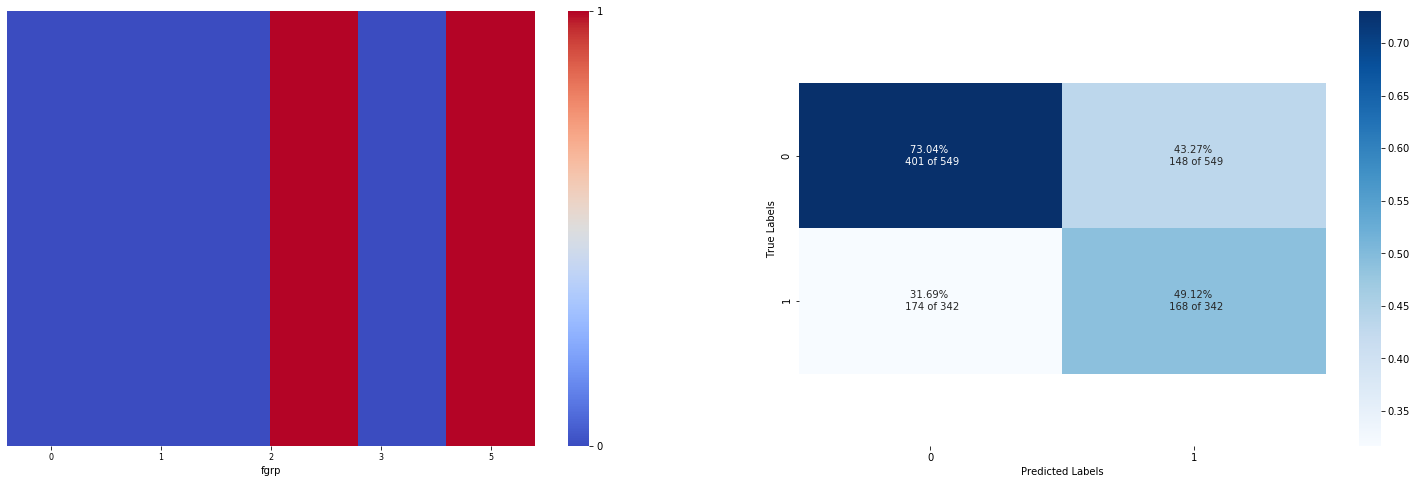

In [108]:
X1 = X['fgrp'].to_frame()

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini')
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', columns='fgrp')
fig = plt.figure()
fig.set_size_inches(26,8)
ax = sns.heatmap(data = hm, ax=fig.add_subplot(1,2,1),
                 cbar_kws={'ticks': [0, 1]},
                 vmin=0, vmax=1,cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(X1['fgrp'].min()).astype(int)
xtmax_l = np.max(X1['fgrp'].max()).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 5))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 5)], fontsize=8)
a = ax.set_yticks([])
a = ax.set_yticklabels([])

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            explained_variance        r2
mean_train            0.494851  0.526915
std_train             0.079274  0.034103
mean_test             0.520311  0.573588
std_test              0.160996  0.151909
{'max_depth': 4, 'n_estimators': 25}


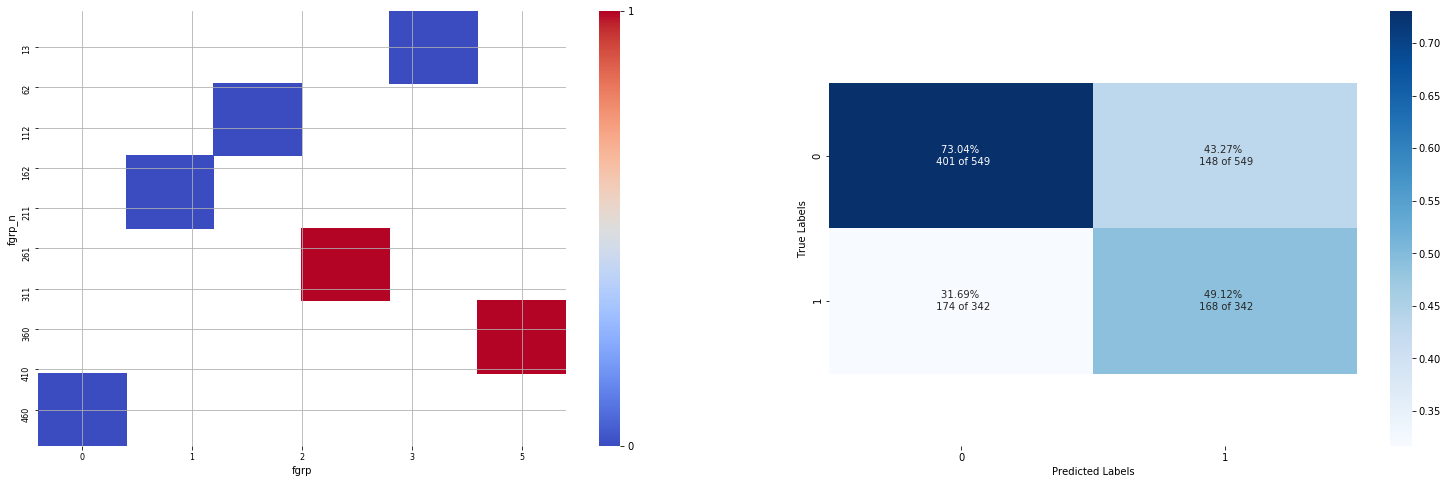

In [109]:
X1 = X['fgrp'].to_frame()
X1['fgrp_n'] = X1['fgrp'].apply(lambda i: len(X1.loc[X1['fgrp']==i].index))

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', 
                               index='fgrp_n',
                               columns='fgrp')

fig = plt.figure()
fig.set_size_inches(26,8)
ax = sns.heatmap(data = hm,
            ax=fig.add_subplot(1,2,1),
                cbar_kws={'ticks': [0, 1]},
                vmin=0,
                vmax=1,
                cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(X1['fgrp'].min()).astype(int)
xtmax_l = np.max(X1['fgrp'].max()).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 5))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 5)], fontsize=8)


ytmin = np.min(ax.get_yticks())
ytmax = np.max(ax.get_yticks())
ytmin_l = np.min(X1['fgrp_n']).astype(int)
ytmax_l = np.max(X1['fgrp_n']).astype(int)
a = ax.set_yticks(np.linspace(ytmin, ytmax, 10))
a = ax.set_yticklabels([i.astype(int) for i in np.linspace(ytmin_l, ytmax_l, 10)], fontsize=8)

ax.grid()

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.656238  0.728500         0.770805
std_train            0.027316  0.009840         0.047891
mean_test            0.602236  0.676699         0.668826
std_test             0.041757  0.019828         0.150451
{'max_depth': 9, 'n_estimators': 5}


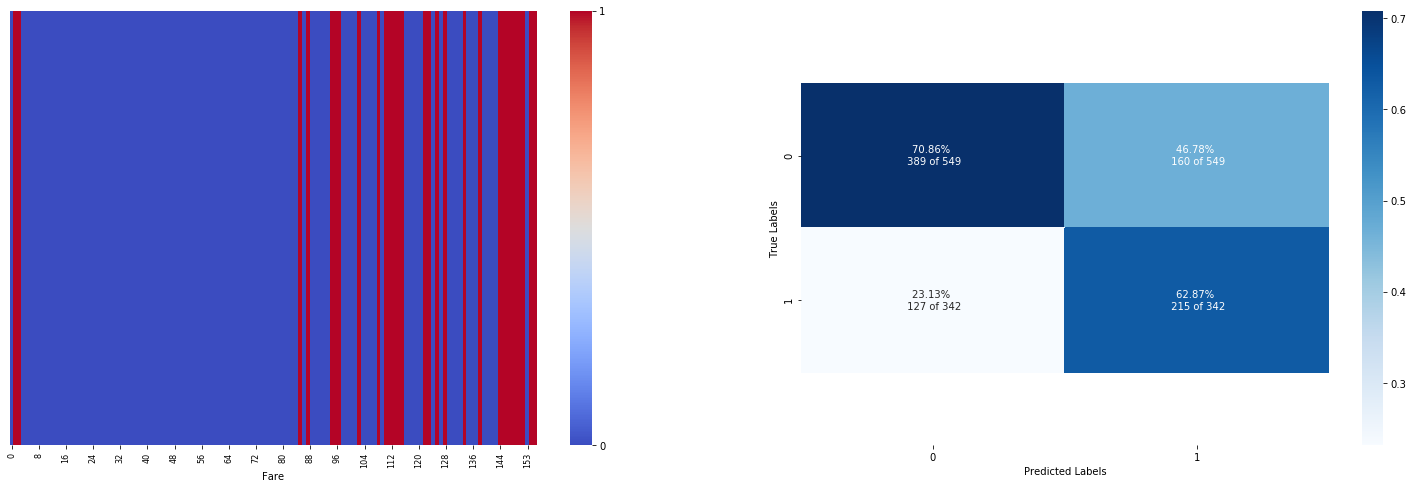

In [716]:
X1 = X['Fare'].to_frame()

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini')
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', columns='Fare')
fig = plt.figure()
fig.set_size_inches(26,8)
ax = sns.heatmap(data = hm, ax=fig.add_subplot(1,2,1),
                 cbar_kws={'ticks': [0, 1]},
                 vmin=0, vmax=1,cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(X1['Fare'].min()).astype(int)
xtmax_l = np.max(X1['Fare'].max()).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 20))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 20)], fontsize=8)
a = ax.set_yticks([])
a = ax.set_yticklabels([])

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.628480  0.712630         0.706469
std_train            0.027777  0.009637         0.091695
mean_test            0.594563  0.687167         0.659231
std_test             0.038234  0.021448         0.101742
{'max_depth': 7, 'n_estimators': 85}


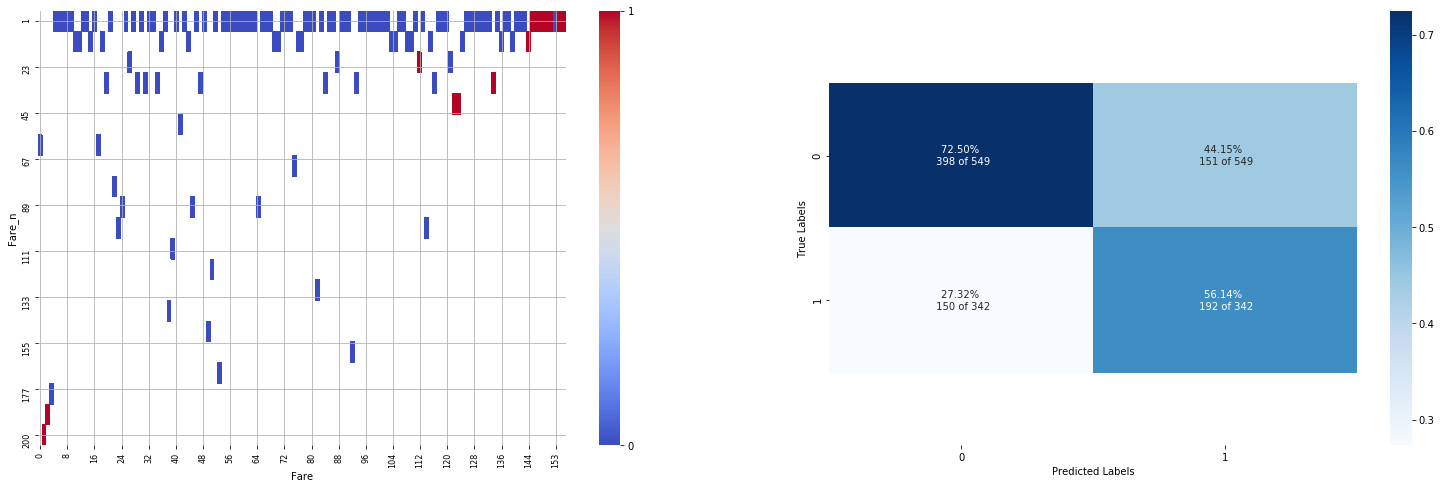

In [718]:
X1 = X['Fare'].to_frame()
X1['Fare_n'] = X1['Fare'].apply(lambda i: len(X1.loc[X1['Fare']==i].index))

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', 
                               index='Fare_n',
                               columns='Fare')

fig = plt.figure()
fig.set_size_inches(26,8)
ax = sns.heatmap(data = hm,
            ax=fig.add_subplot(1,2,1),
                cbar_kws={'ticks': [0, 1]},
                vmin=0,
                vmax=1,
                cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(X1['Fare'].min()).astype(int)
xtmax_l = np.max(X1['Fare'].max()).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 20))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 20)], fontsize=8)


ytmin = np.min(ax.get_yticks())
ytmax = np.max(ax.get_yticks())
ytmin_l = np.min(X1['Fare_n']).astype(int)
ytmax_l = np.max(X1['Fare_n']).astype(int)
a = ax.set_yticks(np.linspace(ytmin, ytmax, 10))
a = ax.set_yticklabels([i.astype(int) for i in np.linspace(ytmin_l, ytmax_l, 10)], fontsize=8)

ax.grid()

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.629517  0.650228         0.640332
std_train            0.009143  0.008675         0.010658
mean_test            0.635699  0.647902         0.644784
std_test             0.023469  0.025460         0.025612
{'max_depth': 4, 'n_estimators': 25}


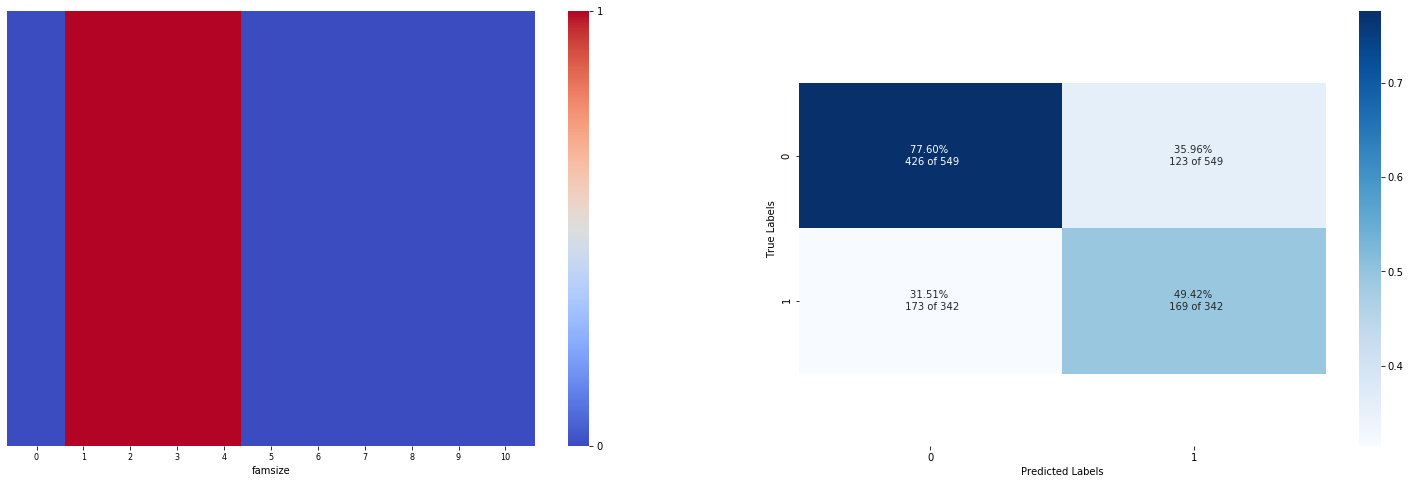

In [723]:
X1 = X['famsize'].to_frame()

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini')
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', columns='famsize')
fig = plt.figure()
fig.set_size_inches(26,8)
ax = sns.heatmap(data = hm, ax=fig.add_subplot(1,2,1),
                 cbar_kws={'ticks': [0, 1]},
                 vmin=0, vmax=1,cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(X1['famsize'].min()).astype(int)
xtmax_l = np.max(X1['famsize'].max()).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 11))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 11)], fontsize=8)
a = ax.set_yticks([])
a = ax.set_yticklabels([])

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.629517  0.650218         0.640332
std_train            0.009143  0.008675         0.010658
mean_test            0.635699  0.649338         0.644784
std_test             0.023469  0.024450         0.025612
{'max_depth': 4, 'n_estimators': 25}


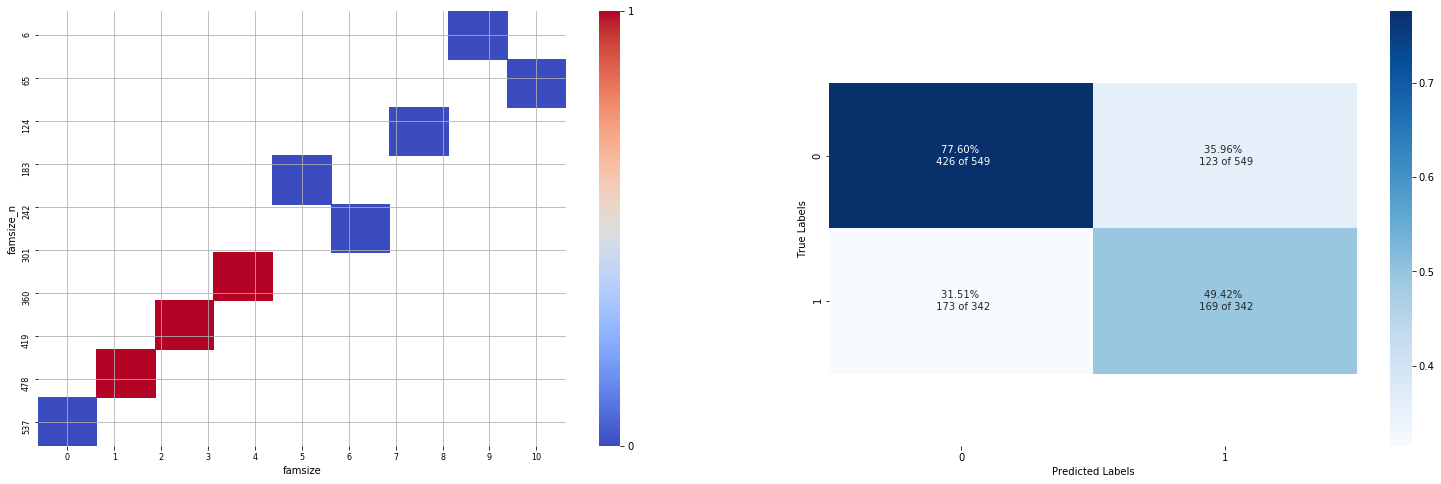

In [724]:
X1 = X['famsize'].to_frame()
X1['famsize_n'] = X1['famsize'].apply(lambda i: len(X1.loc[X1['famsize']==i].index))

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', 
                               index='famsize_n',
                               columns='famsize')

fig = plt.figure()
fig.set_size_inches(26,8)
ax = sns.heatmap(data = hm,
            ax=fig.add_subplot(1,2,1),
                cbar_kws={'ticks': [0, 1]},
                vmin=0,
                vmax=1,
                cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(X1['famsize'].min()).astype(int)
xtmax_l = np.max(X1['famsize'].max()).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 11))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 11)], fontsize=8)


ytmin = np.min(ax.get_yticks())
ytmax = np.max(ax.get_yticks())
ytmin_l = np.min(X1['famsize_n']).astype(int)
ytmax_l = np.max(X1['famsize_n']).astype(int)
a = ax.set_yticks(np.linspace(ytmin, ytmax, 10))
a = ax.set_yticklabels([i.astype(int) for i in np.linspace(ytmin_l, ytmax_l, 10)], fontsize=8)

ax.grid()

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.787209  0.802962         0.786542
std_train            0.009711  0.010921         0.010899
mean_test            0.766184  0.784201         0.769438
std_test             0.027489  0.024440         0.021928
{'max_depth': 3, 'n_estimators': 5}


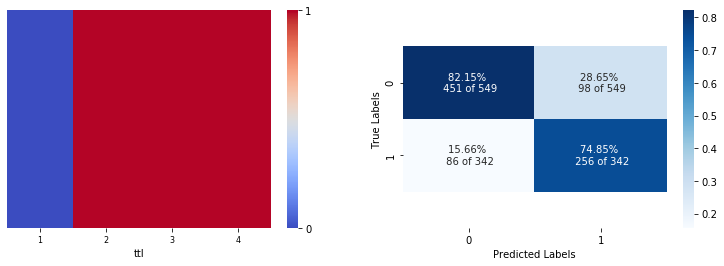

In [711]:
X1 = X['ttl'].to_frame()

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini')
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', columns='ttl')
fig = plt.figure()
fig.set_size_inches(13,4)
ax = sns.heatmap(data = hm, ax=fig.add_subplot(1,2,1),
                 cbar_kws={'ticks': [0, 1]},
                 vmin=0, vmax=1,cmap='coolwarm')
a = ax.set_xticks([0.5,1.5,2.5,3.5])
a = ax.set_xticklabels([1,2,3,4], fontsize=8)
a = ax.set_yticks([])
a = ax.set_yticklabels([])

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.787209  0.802962         0.786542
std_train            0.009711  0.010921         0.010899
mean_test            0.766184  0.784201         0.769438
std_test             0.027489  0.024440         0.021928
{'max_depth': 3, 'n_estimators': 5}


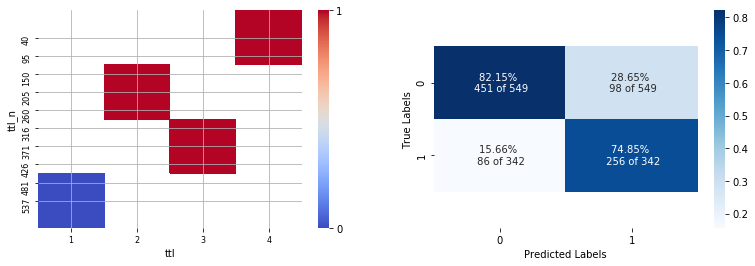

In [713]:
X1 = X['ttl'].to_frame()
X1['ttl_n'] = X1['ttl'].apply(lambda i: len(X1.loc[X1['ttl']==i].index))

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', 
                               index='ttl_n',
                               columns='ttl')

fig = plt.figure()
fig.set_size_inches(13,4)
ax = sns.heatmap(data = hm,
            ax=fig.add_subplot(1,2,1),
                cbar_kws={'ticks': [0, 1]},
                vmin=0,
                vmax=1,
                cmap='coolwarm')
a = ax.set_xticks([0.5,1.5,2.5,3.5])
a = ax.set_xticklabels([1,2,3,4], fontsize=8)


ytmin = np.min(ax.get_yticks())
ytmax = np.max(ax.get_yticks())
ytmin_l = np.min(X1['ttl_n']).astype(int)
ytmax_l = np.max(X1['ttl_n']).astype(int)
a = ax.set_yticks(np.linspace(ytmin, ytmax, 10))
a = ax.set_yticklabels([i.astype(int) for i in np.linspace(ytmin_l, ytmax_l, 10)], fontsize=8)

ax.grid()

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.651693  0.706782         0.659629
std_train            0.020852  0.011648         0.015748
mean_test            0.660227  0.718505         0.679766
std_test             0.027268  0.024523         0.021982
{'max_depth': 3, 'n_estimators': 5}


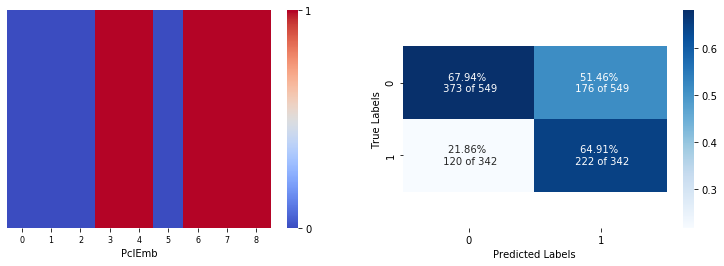

In [729]:
X1 = X['PclEmb'].to_frame()

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini')
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', columns='PclEmb')
fig = plt.figure()
fig.set_size_inches(13,4)
ax = sns.heatmap(data = hm, ax=fig.add_subplot(1,2,1),
                 cbar_kws={'ticks': [0, 1]},
                 vmin=0, vmax=1,cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(X1['PclEmb'].min()).astype(int)
xtmax_l = np.max(X1['PclEmb'].max()).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 9))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 9)], fontsize=8)
a = ax.set_yticks([])
a = ax.set_yticklabels([])

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.649232  0.706751         0.658912
std_train            0.021030  0.011720         0.014918
mean_test            0.658882  0.717994         0.680421
std_test             0.025847  0.024361         0.022162
{'max_depth': 4, 'n_estimators': 5}


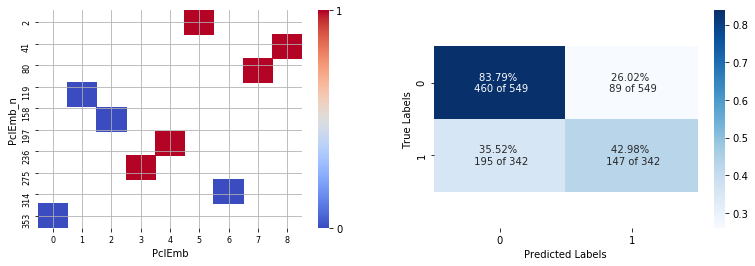

In [731]:
X1 = X['PclEmb'].to_frame()
X1['PclEmb_n'] = X1['PclEmb'].apply(lambda i: len(X1.loc[X1['PclEmb']==i].index))

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini')
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', 
                               index='PclEmb_n',
                               columns='PclEmb')

fig = plt.figure()
fig.set_size_inches(13,4)
ax = sns.heatmap(data = hm,
            ax=fig.add_subplot(1,2,1),
                cbar_kws={'ticks': [0, 1]},
                vmin=0,
                vmax=1,
                cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(X1['PclEmb'].min()).astype(int)
xtmax_l = np.max(X1['PclEmb'].max()).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 9))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 9)], fontsize=8)


ytmin = np.min(ax.get_yticks())
ytmax = np.max(ax.get_yticks())
ytmin_l = np.min(X1['PclEmb_n']).astype(int)
ytmax_l = np.max(X1['PclEmb_n']).astype(int)
a = ax.set_yticks(np.linspace(ytmin, ytmax, 10))
a = ax.set_yticklabels([i.astype(int) for i in np.linspace(ytmin_l, ytmax_l, 10)], fontsize=8)

ax.grid()

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.656029  0.785978         0.742055
std_train            0.014284  0.012690         0.032252
mean_test            0.565875  0.635493         0.752669
std_test             0.014602  0.026342         0.052110
{'max_depth': 9, 'n_estimators': 85}


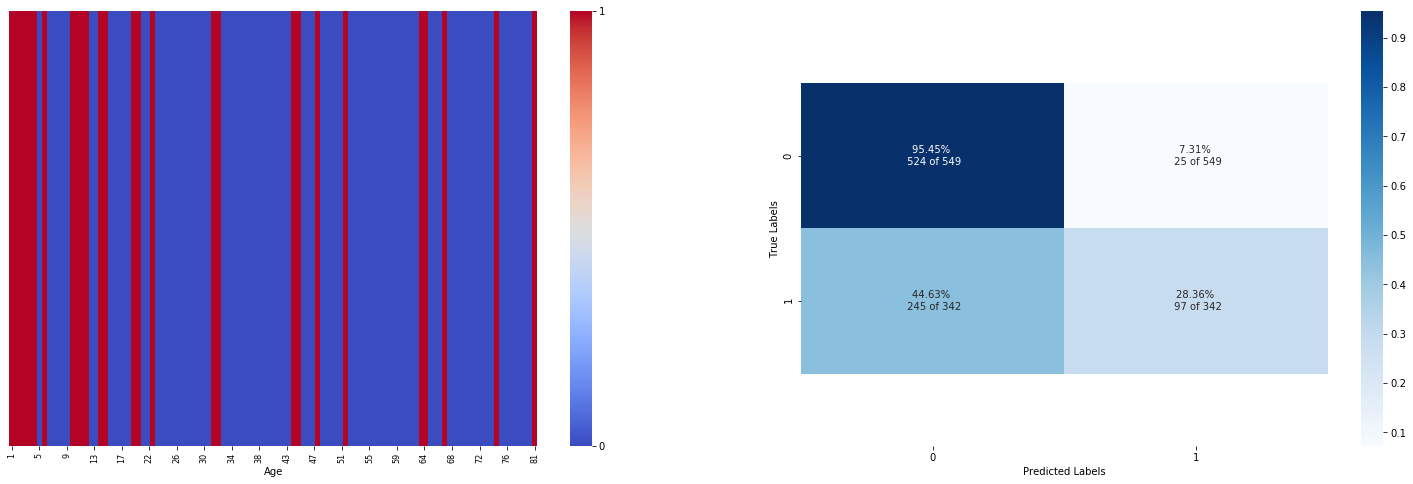

In [695]:
X1 = X['Age'].to_frame()

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini')
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', columns='Age')
fig = plt.figure()
fig.set_size_inches(26,8)
ax = sns.heatmap(data = hm, ax=fig.add_subplot(1,2,1),
                 cbar_kws={'ticks': [0, 1]},
                 vmin=0, vmax=1,cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(np.exp(X1['Age'].min())).astype(int)
xtmax_l = np.max(np.exp(X1['Age'].max())).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 20))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 20)], fontsize=8)
a = ax.set_yticks([])
a = ax.set_yticklabels([])

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.627074  0.767687         0.749234
std_train            0.015933  0.013754         0.035545
mean_test            0.571918  0.632365         0.752315
std_test             0.020242  0.023163         0.051704
{'max_depth': 8, 'n_estimators': 5}


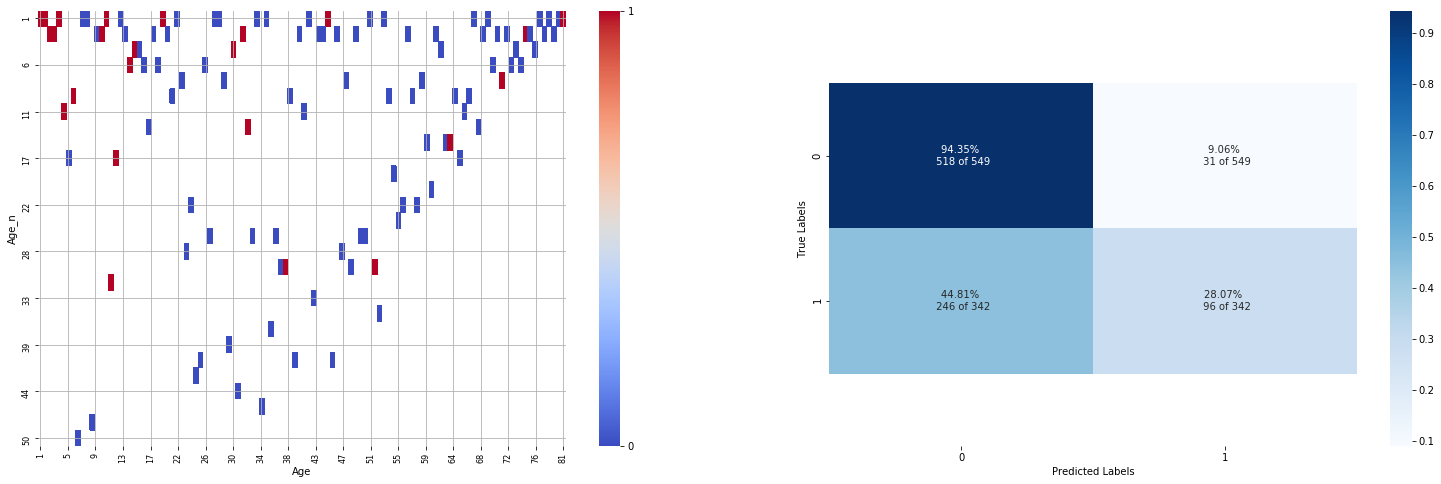

In [694]:
X1 = X['Age'].to_frame()
X1['Age_n'] = X1['Age'].apply(lambda i: len(X1.loc[X1['Age']==i].index))

etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X1, y, scoring, cv, refit=refit)

hm = pd.pivot_table(pd.concat([pd.DataFrame(etc.predict(X1), columns=['pred']), X1.reset_index(drop=True)], axis=1), 
                               values='pred', 
                               index='Age_n',
                               columns='Age')

fig = plt.figure()
fig.set_size_inches(26,8)
ax = sns.heatmap(data = hm,
            ax=fig.add_subplot(1,2,1),
                cbar_kws={'ticks': [0, 1]},
                vmin=0,
                vmax=1,
                cmap='coolwarm')
xtmin = np.min(ax.get_xticks())
xtmax = np.max(ax.get_xticks())
xtmin_l = np.min(np.exp(X1['Age'].min())).astype(int)
xtmax_l = np.max(np.exp(X1['Age'].max())).astype(int)
a = ax.set_xticks(np.linspace(xtmin, xtmax, 20))
a = ax.set_xticklabels([i.astype(int) for i in np.linspace(xtmin_l, xtmax_l, 20)], fontsize=8)


ytmin = np.min(ax.get_yticks())
ytmax = np.max(ax.get_yticks())
ytmin_l = np.min(X1['Age_n']).astype(int)
ytmax_l = np.max(X1['Age_n']).astype(int)
a = ax.set_yticks(np.linspace(ytmin, ytmax, 10))
a = ax.set_yticklabels([i.astype(int) for i in np.linspace(ytmin_l, ytmax_l, 10)], fontsize=8)

ax.grid()

plot_confusion_matrix(etc, X1, y, ax=fig.add_subplot(1,2,2), normalize=True, title='')

In [242]:
base_scores = {}

In [243]:
gpc = gaup.GaussianProcessClassifier(kernel=None, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, random_state=random_state)
param_ranges = {'max_iter_predict': np.arange(1, 50, 10)}
gpc, scores = train_best_model(gpc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['gpc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.847046  0.899411         0.844271
std_train            0.011824  0.010936         0.011629
mean_test            0.782830  0.845887         0.810779
std_test             0.022836  0.020430         0.021805
{'max_iter_predict': 11}


In [244]:
lda = disan.LinearDiscriminantAnalysis(solver='svd', shrinkage=None)
param_ranges = {'n_components': np.arange(1,10)}
lda, scores = train_best_model(lda, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lda'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.761846  0.825136         0.788665
std_train            0.011345  0.012484         0.010207
mean_test            0.749882  0.816061         0.783825
std_test             0.028004  0.019346         0.024555
{'n_components': 1}


In [245]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]])
param_ranges = {'reg_param': np.linspace(0.01,1,12)}
qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['qda'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.790406  0.841363         0.822822
std_train            0.013314  0.013270         0.016805
mean_test            0.776149  0.837585         0.812712
std_test             0.023877  0.020622         0.030971
{'reg_param': 0.01}


In [246]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', random_state=random_state)
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.3, 20)}
abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['abc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.822131  0.900337         0.838482
std_train            0.010867  0.010938         0.010318
mean_test            0.805040  0.870771         0.822817
std_test             0.023027  0.021926         0.023039
{'learning_rate': 0.12689473684210525, 'n_estimators': 85}


Optimal number of features : 5
Features to drop: 

[]


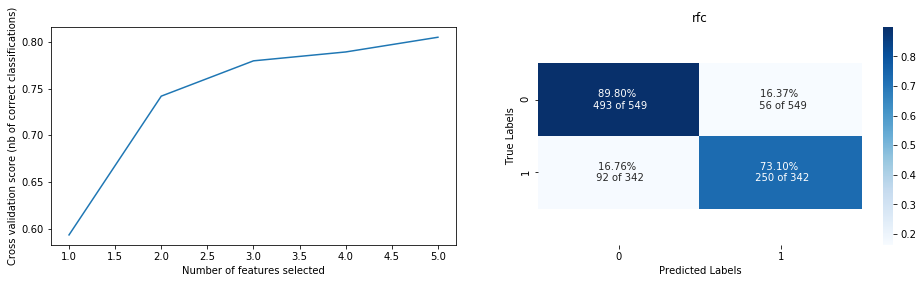

In [247]:
rfecv = feature_selection.RFECV(estimator=abc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(abc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [291]:
gbc = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                     min_samples_split=2, min_samples_leaf=1,
                                     init=None, random_state=random_state, 
                                     max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 10), 'n_estimators': np.arange(5, 100, 20)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'min_impurity_decrease': np.linspace(0.01, 0.2, 15)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'subsample': np.linspace(0.1, 1.1, 15), 'max_depth': np.arange(3, 6)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 15)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

base_scores['gbc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.869601  0.953054         0.855387
std_train            0.012038  0.006703         0.008535
mean_test            0.802610  0.881112         0.858210
std_test             0.023990  0.021066         0.009716
{'learning_rate': 0.09444444444444444, 'n_estimators': 65}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.848428  0.936039         0.842718
std_train            0.011094  0.009486         0.009712
mean_test            0.800544  0.882330         0.826331
std_test             0.026519  0.019991         0.024127
{'min_impurity_decrease': 0.09142857142857143, 'min_weight_fraction_leaf': 0.01}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.896476  0.946788         0.877728
std_train            0.010999  0.007147         0.009400
mean_test            0.802980  0.882969         0.823932
std_test             0.029469  0.022527         0.023818
{'max

Optimal number of features : 5
Features to drop: 

[]


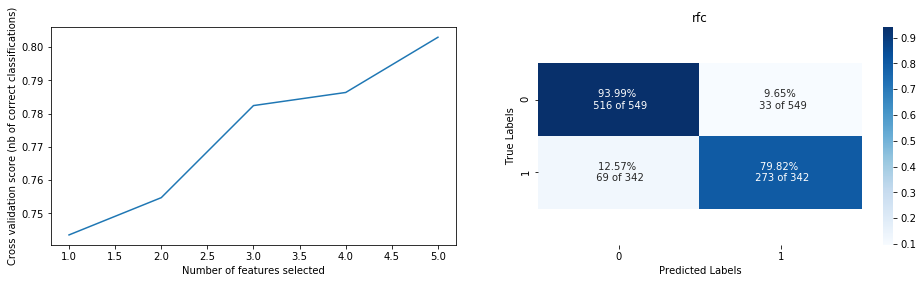

In [249]:
rfecv = feature_selection.RFECV(estimator=gbc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(gbc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [292]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 15)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

base_scores['etc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.822799  0.918782         0.855641
std_train            0.010153  0.008143         0.008586
mean_test            0.800791  0.873466         0.827815
std_test             0.024154  0.020532         0.024311
{'max_depth': 3, 'n_estimators': 45}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.822799  0.869093         0.838350
std_train            0.010153  0.010841         0.011103
mean_test            0.800791  0.854375         0.820597
std_test             0.024154  0.017921         0.021350
{'ccp_alpha': 1e-05}


Optimal number of features : 4
Features to drop: 

['Age']


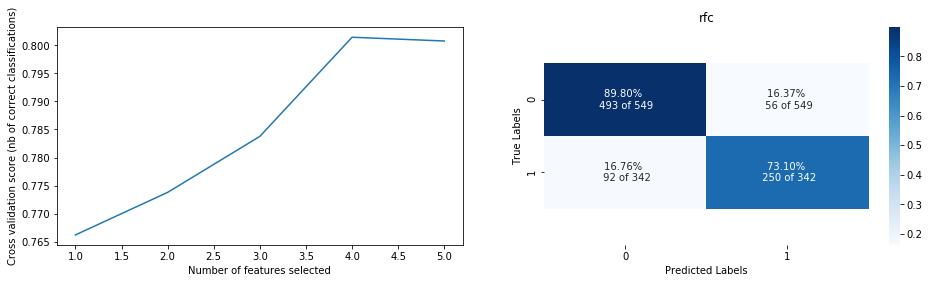

In [251]:
rfecv = feature_selection.RFECV(estimator=etc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(etc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [293]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'base_estimator__n_estimators': np.arange(5, 100, 20),
                'base_estimator__max_depth': np.arange(5, 10)}
rfc, scores = train_best_model_cal(rfc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'ccp_alpha': np.linspace(0.001, 0.01, 15)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

base_scores['rfc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.869254  0.956691         0.877577
std_train            0.015084  0.007019         0.011915
mean_test            0.797690  0.880012         0.826954
std_test             0.023288  0.018722         0.023181
{'base_estimator__max_depth': 7, 'base_estimator__n_estimators': 45}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.982022  0.997988         0.985546
std_train            0.004664  0.000874         0.004336
mean_test            0.791100  0.867458         0.800943
std_test             0.023119  0.020736         0.020778
{'ccp_alpha': 1e-05}


Optimal number of features : 5
Features to drop: 

[]


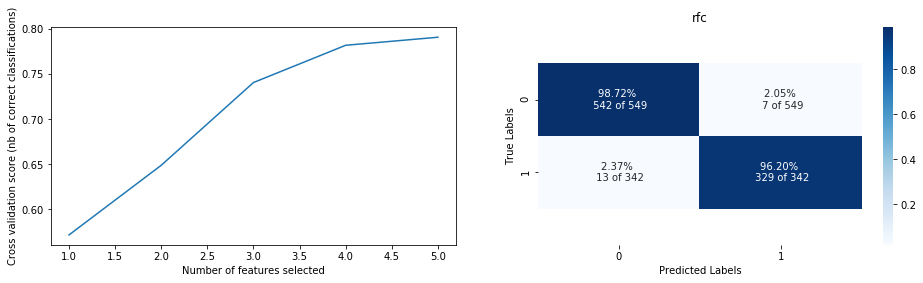

In [253]:
rfecv = feature_selection.RFECV(estimator=rfc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(rfc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [254]:
lr = lm.LogisticRegression(class_weight=class_weights, random_state=random_state, n_jobs=-1)
param_ranges = {'base_estimator__C': np.linspace(0.01, 5, 20)}
lr, scores = train_best_model_cal(lr, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lr'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.755851  0.825103         0.785781
std_train            0.012932  0.012386         0.014845
mean_test            0.740853  0.815302         0.771721
std_test             0.027267  0.019797         0.029484
{'base_estimator__C': 0.27263157894736845}


In [255]:
pac = lm.PassiveAggressiveClassifier(class_weight=class_weights, random_state=random_state, n_jobs=-1)
param_ranges = {'C': np.linspace(0.01, 1, 20)}
pac, scores = train_best_model(pac, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['pac'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.743828  0.813160         0.741646
std_train            0.030237  0.013045         0.037632
mean_test            0.717214  0.798155         0.721299
std_test             0.035358  0.013293         0.046510
{'C': 0.01}


In [256]:
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state, solver='auto')
param_ranges = {'alpha': np.linspace(0.01, 40, 20)}
rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['rc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.754891  0.825520         0.755065
std_train            0.018061  0.012432         0.019215
mean_test            0.741686  0.816331         0.743762
std_test             0.022608  0.019061         0.021022
{'alpha': 0.01}


In [257]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights)
param_ranges = {'base_estimator__C': np.linspace(0.01, 10, 20)}
svc, scores = train_best_model_cal(svc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['svc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.809398  0.884553         0.835023
std_train            0.011522  0.012465         0.010864
mean_test            0.794042  0.866252         0.827144
std_test             0.023514  0.021596         0.019640
{'base_estimator__C': 3.690526315789474}


In [258]:
lsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', class_weight=class_weights, max_iter=1500, tol=0.05)
param_ranges = {'base_estimator__C': np.linspace(0.005, 1, 20)}
lsvc, scores = train_best_model_cal(lsvc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lsvc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.758364  0.824098         0.787957
std_train            0.016134  0.012231         0.014784
mean_test            0.750733  0.813560         0.785009
std_test             0.019709  0.018927         0.015513
{'base_estimator__C': 0.4763157894736842}


In [259]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights)
param_ranges = {'nu': np.linspace(0.1,1,10)}
nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['nusvc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.811963  0.875878         0.838464
std_train            0.011419  0.008055         0.011548
mean_test            0.788879  0.864928         0.831540
std_test             0.020083  0.019586         0.018202
{'nu': 0.4}


In [284]:
pd.Series(base_scores, name='test').sort_values(ascending=False)

abc      0.805040
gbc      0.802980
etc      0.800791
rfc      0.797690
svc      0.794042
nusvc    0.788879
gpc      0.782830
lsvc     0.750733
lda      0.749882
rc       0.741686
lr       0.740853
pac      0.717214
Name: test, dtype: float64

In [285]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [723]:
# base_models_surv_dic = {'qda':qda,'abc':abc,'etc':etc,'pac':pac,'rc':rc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [286]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

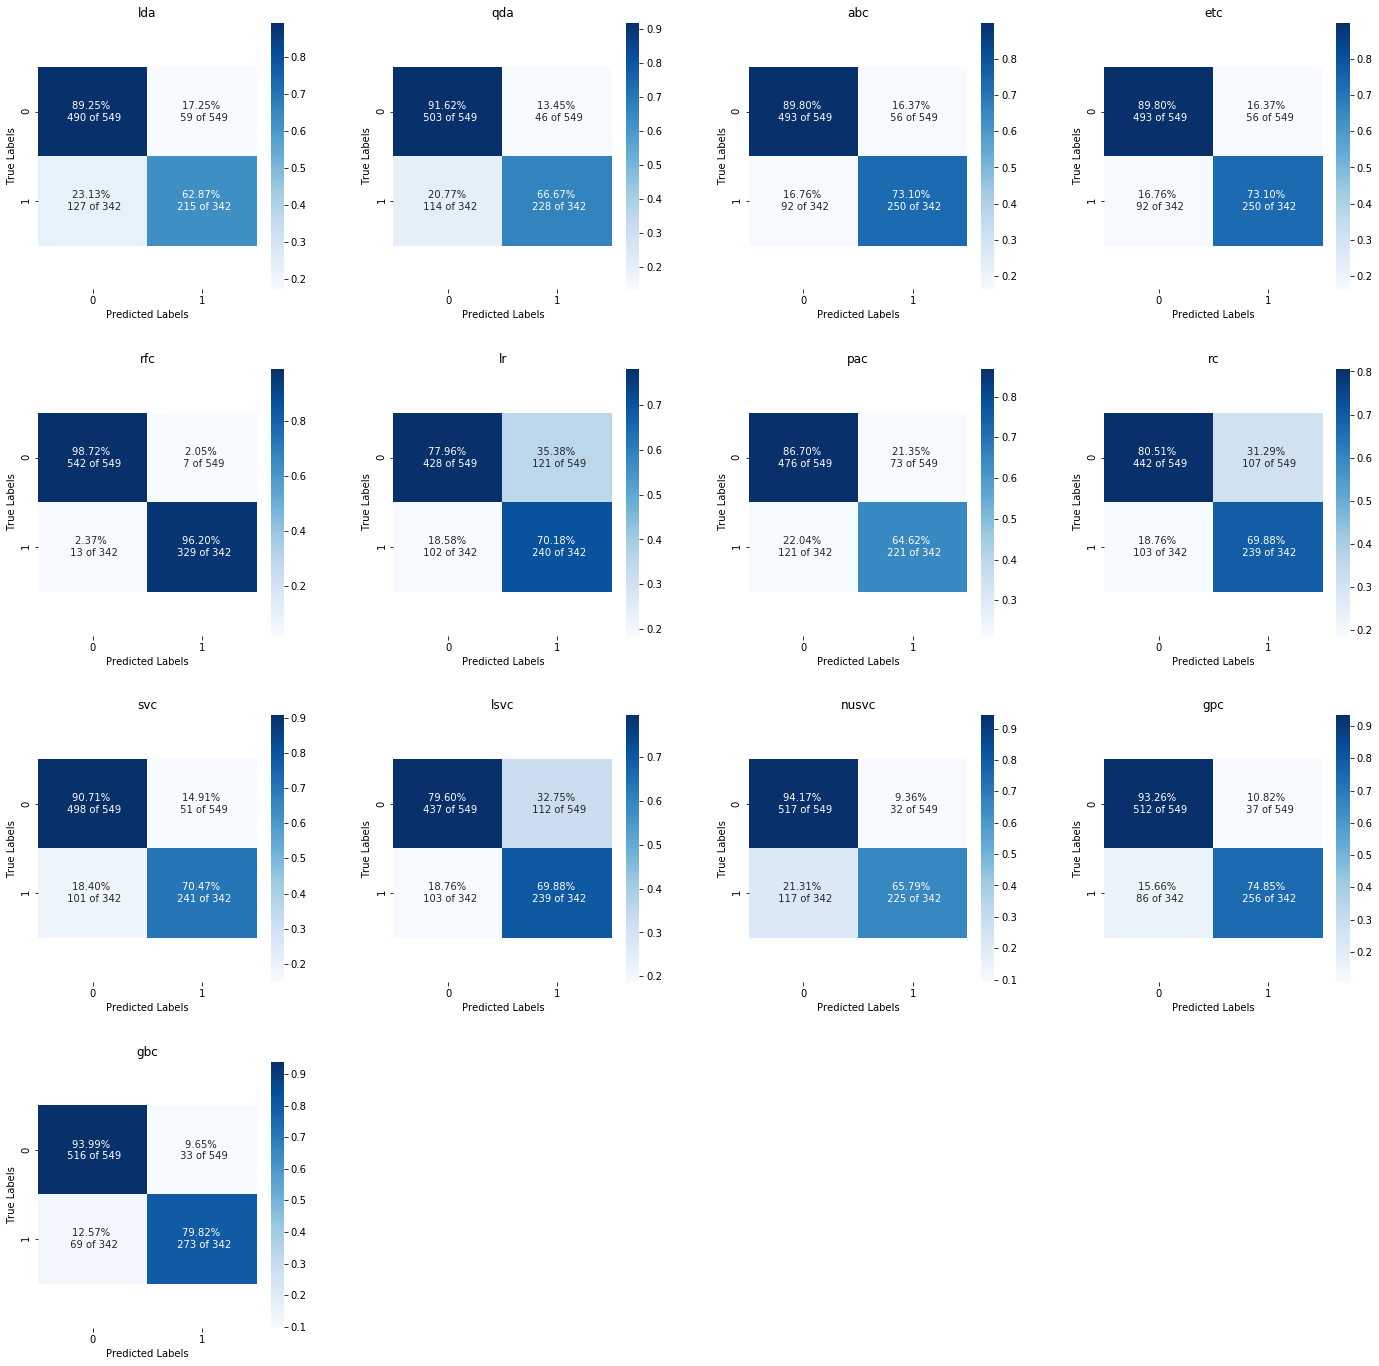

In [287]:
grd_n = len(base_models_surv)
grd_cols_n = 4
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

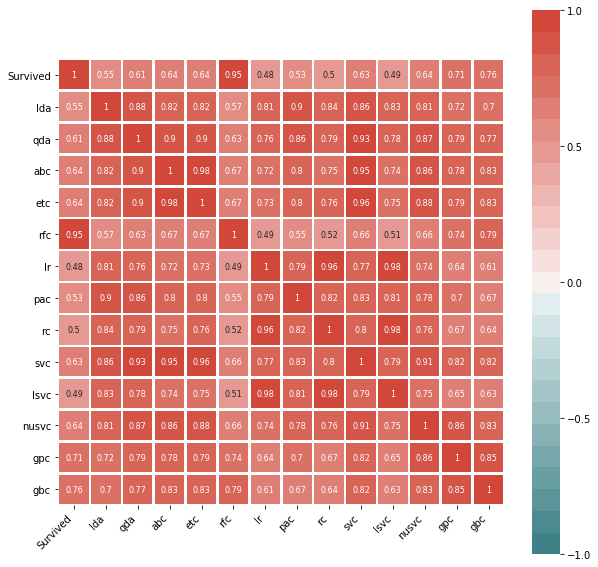

In [288]:
preds_base = base_models_predictions(base_models_surv, X)
preds_base = pd.concat([y.reset_index().drop(columns=['index']), preds_base], axis=1)
# data = pd.concat([pd.DataFrame(final_model_surv_st.predict_proba(X_test), columns=['final_pred_0', 'final_pred_1']), data], axis=1)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [289]:
corr_matrix.drop(index='Survived')

,Survived,lda,qda,abc,etc,rfc,lr,pac,rc,svc,lsvc,nusvc,gpc,gbc
lda,0.549256,1.000000,0.878781,0.824090,0.824090,0.565412,0.807453,0.903060,0.836359,0.861186,0.826563,0.805092,0.724241,0.701167
qda,0.614270,0.878781,1.000000,0.895795,0.895795,0.630648,0.762865,0.856507,0.791447,0.928546,0.781766,0.869514,0.791541,0.772872
abc,0.644176,0.824090,0.895795,1.000000,0.980090,0.666182,0.722266,0.799389,0.752515,0.950267,0.737444,0.864666,0.781686,0.825792
etc,0.644176,0.824090,0.895795,0.980090,1.000000,0.666182,0.731895,0.799389,0.762214,0.960338,0.747118,0.880317,0.791748,0.825792
rfc,0.952485,0.565412,0.630648,0.666182,0.666182,1.000000,0.489937,0.547315,0.515635,0.655593,0.505378,0.664928,0.736958,0.788099
lr,0.476839,0.807453,0.762865,0.722266,0.731895,0.489937,1.000000,0.787090,0.960747,0.772926,0.976880,0.736123,0.638888,0.611534
pac,0.530824,0.903060,0.856507,0.799389,0.799389,0.547315,0.787090,1.000000,0.821967,0.832200,0.806917,0.780818,0.697695,0.673723
rc,0.502844,0.836359,0.791447,0.752515,0.762214,0.515635,0.960747,0.821967,1.000000,0.802679,0.978861,0.763483,0.667725,0.640975
svc,0.633857,0.861186,0.928546,0.950267,0.960338,0.655593,0.772926,0.832200,0.802679,1.000000,0.787710,0.911893,0.819320,0.819347
lsvc,0.492492,0.826563,0.781766,0.737444,0.747118,0.505378,0.976880,0.806917,0.978861,0.787710,1.000000,0.749145,0.653086,0.626190


In [290]:
cm = corr_matrix.drop(index='Survived')
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (cm[k].sum() - 1) / len(cm.index)
    
df_base_models_corr_sc = pd.concat([cm['Survived'], pd.Series(corr_sc)], axis=1)
df_base_models_corr_sc.sort_values(by=0, ascending=False)

,Survived,0
svc,0.633857,0.777077
etc,0.644176,0.758844
qda,0.614270,0.758160
abc,0.644176,0.753860
nusvc,0.643657,0.747399
lda,0.549256,0.735192
pac,0.530824,0.715851
rc,0.502844,0.714970
lsvc,0.492492,0.705928
gpc,0.705104,0.693219


In [263]:
#opt
# base_models_surv_dic = {'rfc':rfc,'lr':lr,'pac':pac,'svc':svc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc,'qda':qda}

In [267]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'lr':lr,'pac':pac,'rc':rc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc}

In [572]:
# base_models_surv_dic = {'lda':lda,'qda':qda,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'svc':svc,'gpc':gpc,'gbc':gbc}

In [271]:
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                                                                 random_state=random_state,
                                                                                 ccp_alpha=0.0),
                                  cv=5, 
                                  stack_method='predict', 
                                  n_jobs=-1)
cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.851822,0.908162,0.868367
std_train,0.021717,0.021994,0.018304
mean_test,0.793695,0.830774,0.814185
std_test,0.018070,0.020152,0.016695


In [272]:
param_ranges = {'final_estimator__learning_rate': np.linspace(0.01, 0.2, 10), 'final_estimator__n_estimators': np.arange(5, 100, 20)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

In [ ]:
param_ranges = {'final_estimator__min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'final_estimator__min_impurity_decrease': np.linspace(0.01, 0.2, 15)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

In [272]:
param_ranges = {'final_estimator__subsample': np.linspace(0.1, 1.1, 15), 'final_estimator__max_depth': np.arange(3, 6)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.844392  0.916691         0.866346
std_train            0.024481  0.029561         0.019699
mean_test            0.804434  0.841548         0.827068
std_test             0.021756  0.023320         0.018628
{'final_estimator__learning_rate': 0.11555555555555555, 'final_estimator__n_estimators': 25}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.843593  0.921670         0.862220
std_train            0.016341  0.030471         0.018248
mean_test            0.805463  0.844016         0.827564
std_test             0.025311  0.024606         0.023803
{'final_estimator__min_impurity_decrease': 0.07785714285714285, 'final_estimator__min_weight_fraction_leaf': 0.052222222222222225}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.841678  0.951903         0.857311
std_train            0.013301  0.007677         0.018427
mean_test            0.805040  0.84

In [277]:
param_ranges = {'final_estimator__ccp_alpha': np.linspace(0.00001, 0.00005, 15)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.841190  0.951926         0.859184
std_train            0.012947  0.007685         0.014287
mean_test            0.804857  0.845225         0.824997
std_test             0.024432  0.020072         0.022462
{'final_estimator__ccp_alpha': 1.5714285714285715e-05}


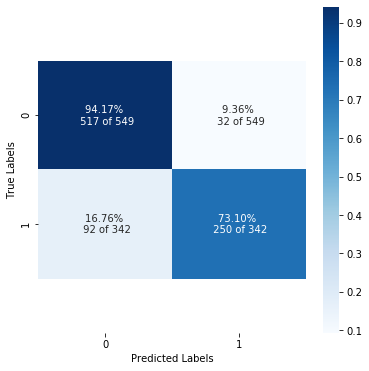

In [278]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [279]:
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, 
                                                                             criterion='gini'),
                                  cv=5, 
                                  stack_method='predict', 
                                  n_jobs=-1)
cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.841105,0.910727,0.856444
std_train,0.021029,0.026588,0.015893
mean_test,0.795940,0.827593,0.815156
std_test,0.015279,0.019991,0.016605


In [280]:
param_ranges = {'final_estimator__n_estimators': np.arange(5, 100, 20),
                'final_estimator__max_depth': np.arange(5, 10)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.836252  0.930963         0.855214
std_train            0.031557  0.020355         0.026910
mean_test            0.802065  0.842510         0.822747
std_test             0.017782  0.023172         0.018097
{'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 25}


In [281]:
param_ranges = {'final_estimator__ccp_alpha': np.linspace(0.00001, 0.00005, 15)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.834760  0.929150         0.853438
std_train            0.032864  0.021565         0.028762
mean_test            0.802854  0.841689         0.823579
std_test             0.018185  0.021552         0.018356
{'final_estimator__ccp_alpha': 4.428571428571429e-05}


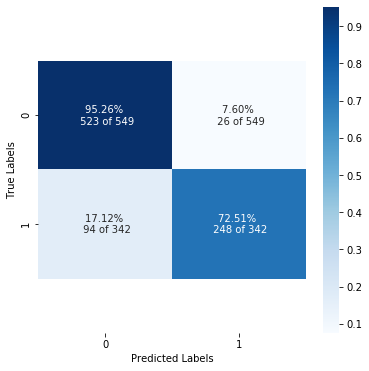

In [282]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [573]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

In [266]:
def train_final_models(models, X, y, score, cv_folds=5):
    scores = {}
    for m in models:
        model_st = ens.StackingClassifier(estimators=base_models_surv,
                                          final_estimator=m[1],
                                          cv=cv_folds, 
                                          stack_method='predict', 
                                          n_jobs=-1)
        res = cv_rep(model_st, X, y, cv, scoring)
        scores[m[0]] = res.loc['mean_test', score]
    return pd.DataFrame(scores, index=['Test_score'])

In [268]:
train_final_models(base_models_surv, X, y, cv_folds=5, score=refit)

,lda,qda,abc,etc,rfc,lr,pac,rc,svc,lsvc,nusvc,gpc,gbc
Test_score,0.796113,0.638942,0.795127,0.778887,0.778593,0.787908,0.702181,0.791251,0.781535,0.791251,0.795727,0.790953,0.778593


In [647]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [648]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

In [649]:
train_final_models(base_models_surv, X, y, cv_folds=5, score='accuracy')

,rfc,lr,pac,svc,nusvc,gpc,gbc,qda
Test_score,0.794776,0.805504,0.740672,0.803638,0.803172,0.801772,0.798974,0.78125


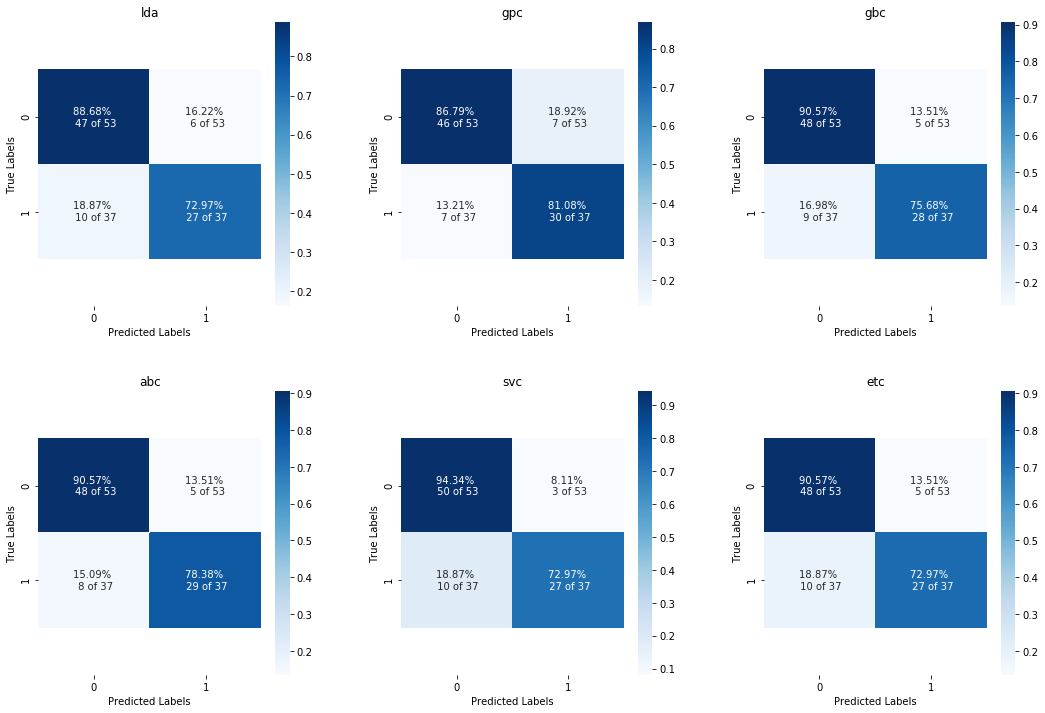

In [444]:
grd_n = len(fin_models_surv)
grd_cols_n = 3
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(fin_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X_test, y_test, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [440]:
fin_models_surv_dic = {'lda':lda,'gpc':gpc,'gbc':gbc,'abc':abc,'svc':svc,'etc':etc}

In [441]:
fin_models_surv = [(k,fin_models_surv_dic[k]) for k in fin_models_surv_dic.keys()]

In [398]:
pred_test = final_model_surv_vt.predict_proba(X_test)
len(pred_test[:,1]>0.9)

90